In [1]:
from mnn import mnn_core, models, utils, analysis, snn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from torch.utils.data import DataLoader

%matplotlib inline

In [9]:
data_dir = './data/nips_rebuttal/data/'
img_dir = './data/nips_rebuttal/img/'
utils.training_tools.RecordMethods.make_dir(img_dir)
utils.training_tools.RecordMethods.make_dir(data_dir)
cm = analysis.get_plt_cm_size()
plt.rcdefaults()
sns.reset_defaults()
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14

# ANN2SNN validation CIFAR100

In [3]:
import sys
sys.path.append('../')
sys.path.append('../ANN2SNN_SRP/')
from ANN2SNN_SRP import main as ann2snn
from ANN2SNN_SRP import utils as ann2snn_utils
from ANN2SNN_SRP import dataprocess as ann2snn_dataprocess

In [34]:
path = '../ANN2SNN_SRP/'
sim_len = 100
presim_len = 0
L = 4
dt = 1
name = 'QCFS_CIFAR100_resnet20_L4'
model = ann2snn.resnet20(num_classes=100)
model = ann2snn_utils.replace_maxpool2d_by_avgpool2d(model)
model = ann2snn_utils.replace_activation_by_floor(model, L)
model.load_state_dict(torch.load(path + 'saved_models/' + name + '.pth'))
model = ann2snn_utils.replace_activation_by_MPLayer(model, presim_len=presim_len,sim_len=sim_len)
model = ann2snn_utils.replace_MPLayer_by_neuron(model)
print(model)

ResNet4Cifar(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): IFNeuron(
      (neuron): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
    )
  )
  (conv2_x): Sequential(
    (0): BasicBlock(
      (residual_function): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): IFNeuron(
          (neuron): IFNode(
            v_threshold=1.0, v_reset=None, detach_reset=False
            (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
          )
        )
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, mome

In [35]:
batch_size = 50
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[n/255. for n in [129.3, 124.1, 112.4]], std=[n/255. for n in [68.2,  65.4,  70.4]])])
test_data = datasets.CIFAR100('./data/', train=False, transform=trans, download=True) 
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [37]:
def eval_snn(model, dataloader, sim_len=100, device=0):
    result = []
    targets = []
    model = model.cuda(device)
    model.eval()
    with torch.no_grad():
        for img, label in tqdm(dataloader):
            case = []
            img = img.cuda(device)
            targets.append(label)
            for t in range(sim_len):
                out = model(img)
                case.append(out.unsqueeze(0))
            case = torch.cat(case, dim=0).cpu()
            result.append(case)
            ann2snn_utils.reset_net(model)
    result = torch.cat(result, dim=1)
    targets = torch.cat(targets)
    return result, targets

In [38]:
result, targets = eval_snn(model, test_dataloader, sim_len=sim_len)
print(result.shape, targets.shape)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


torch.Size([100, 10000, 100]) torch.Size([10000])


In [39]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

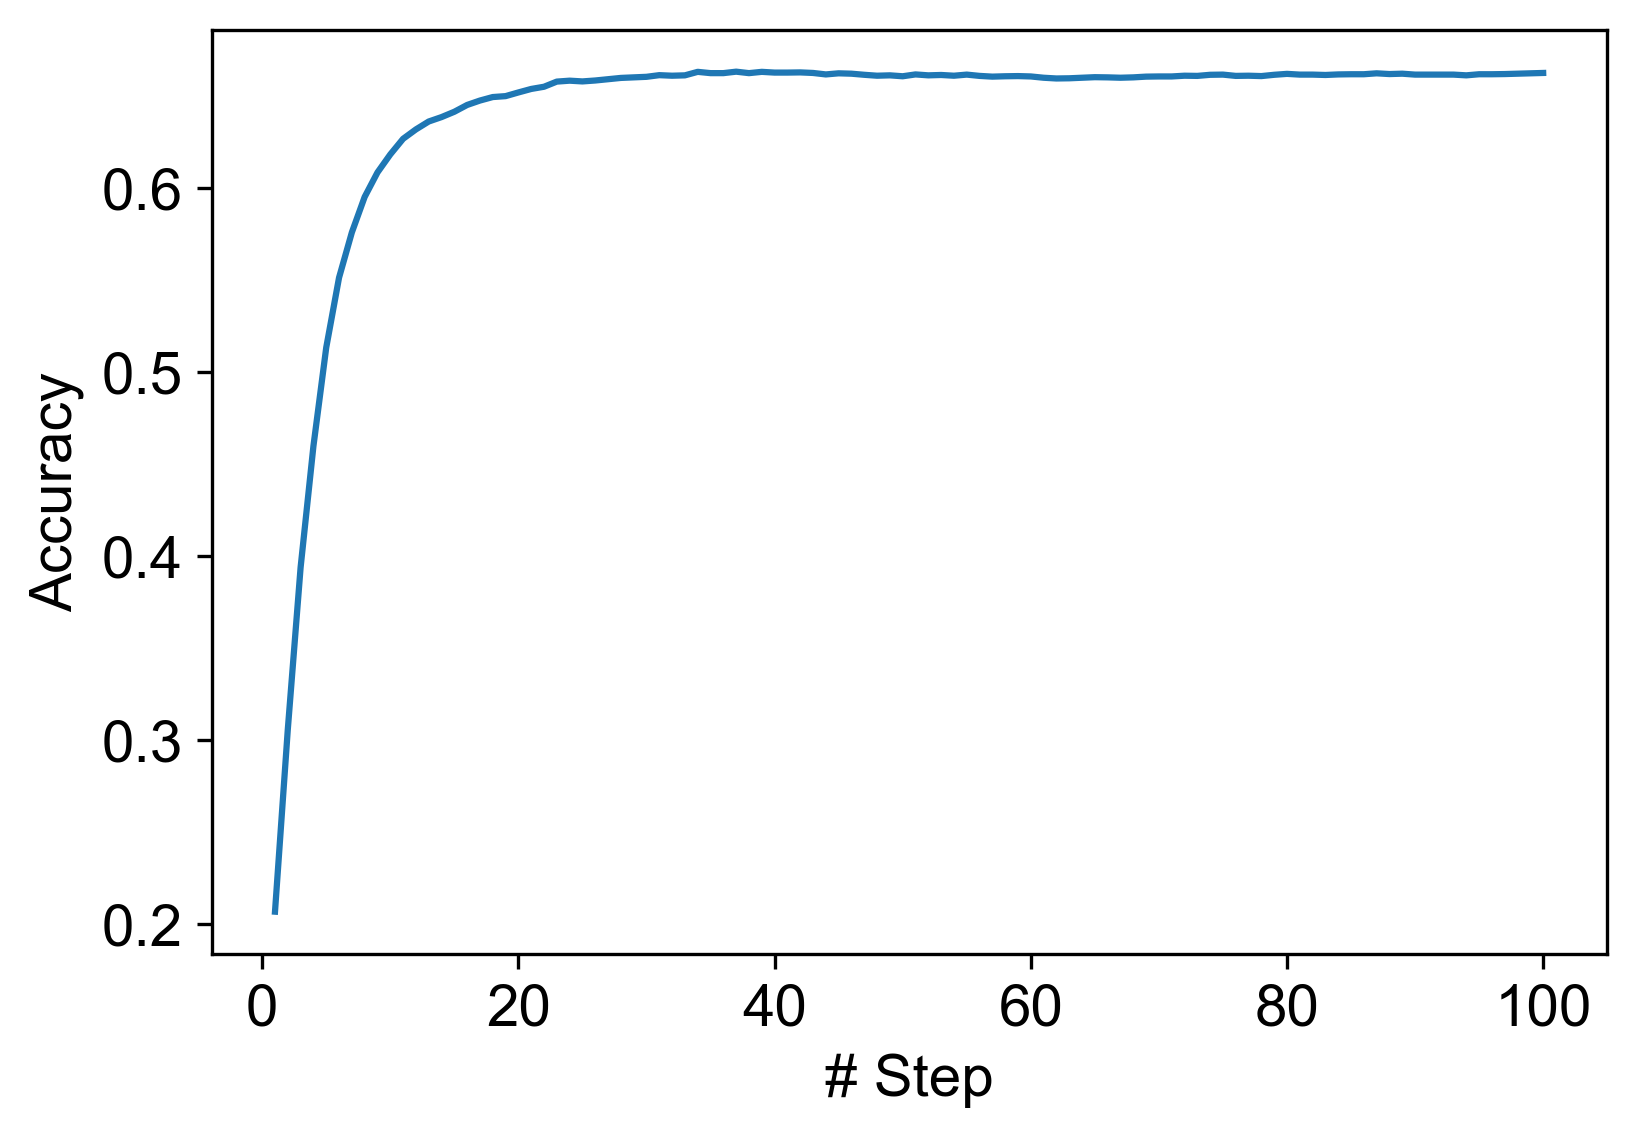

In [40]:
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [41]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step /  torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([10000])


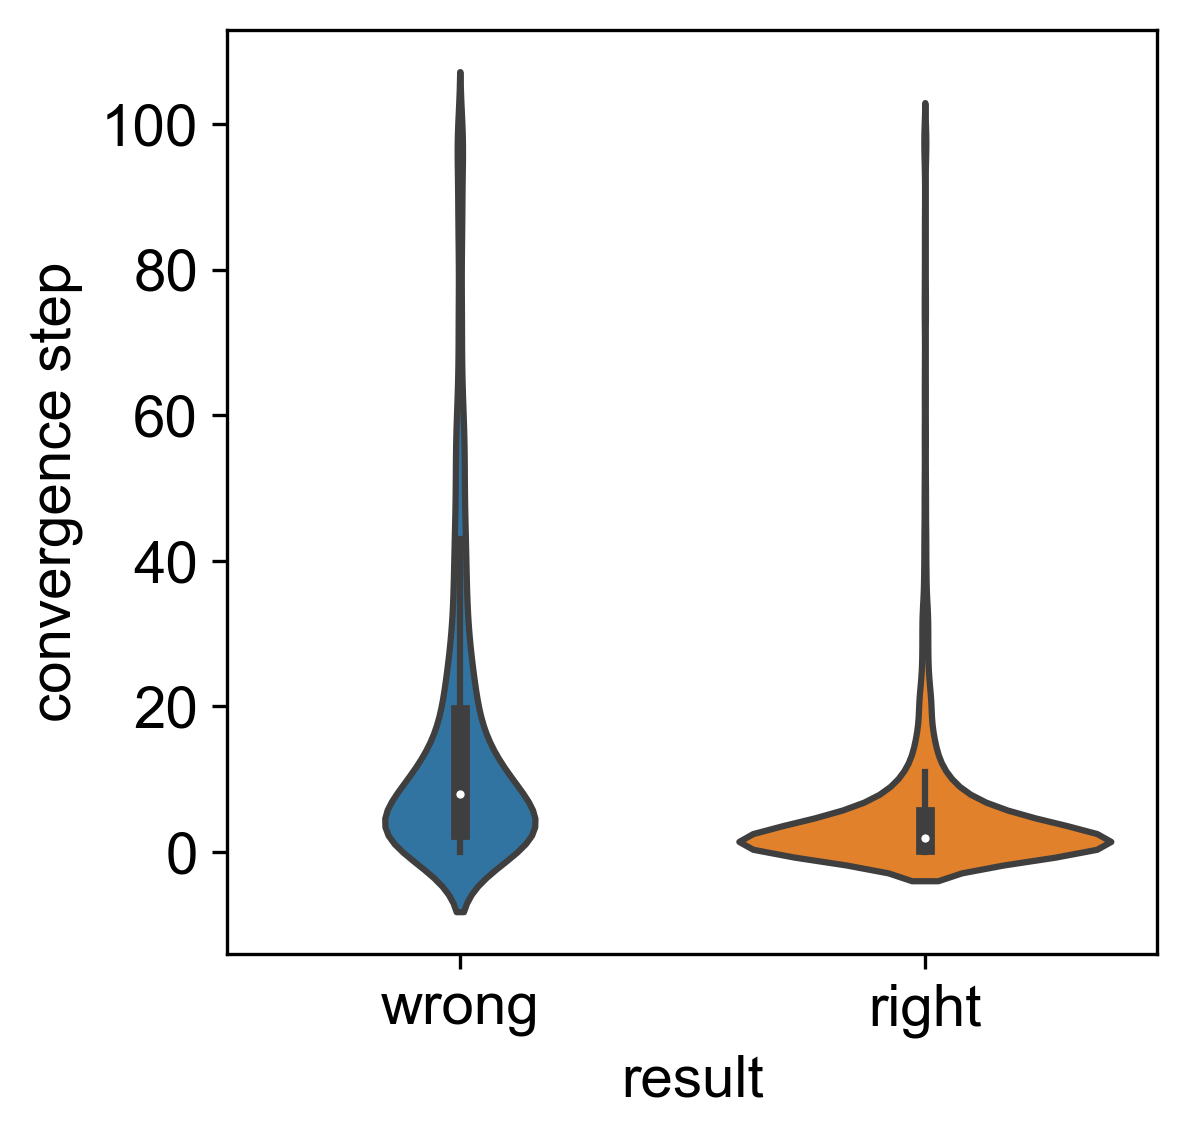

In [42]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([100, 10000])
2500 7500 torch.Size([100]) torch.Size([100])


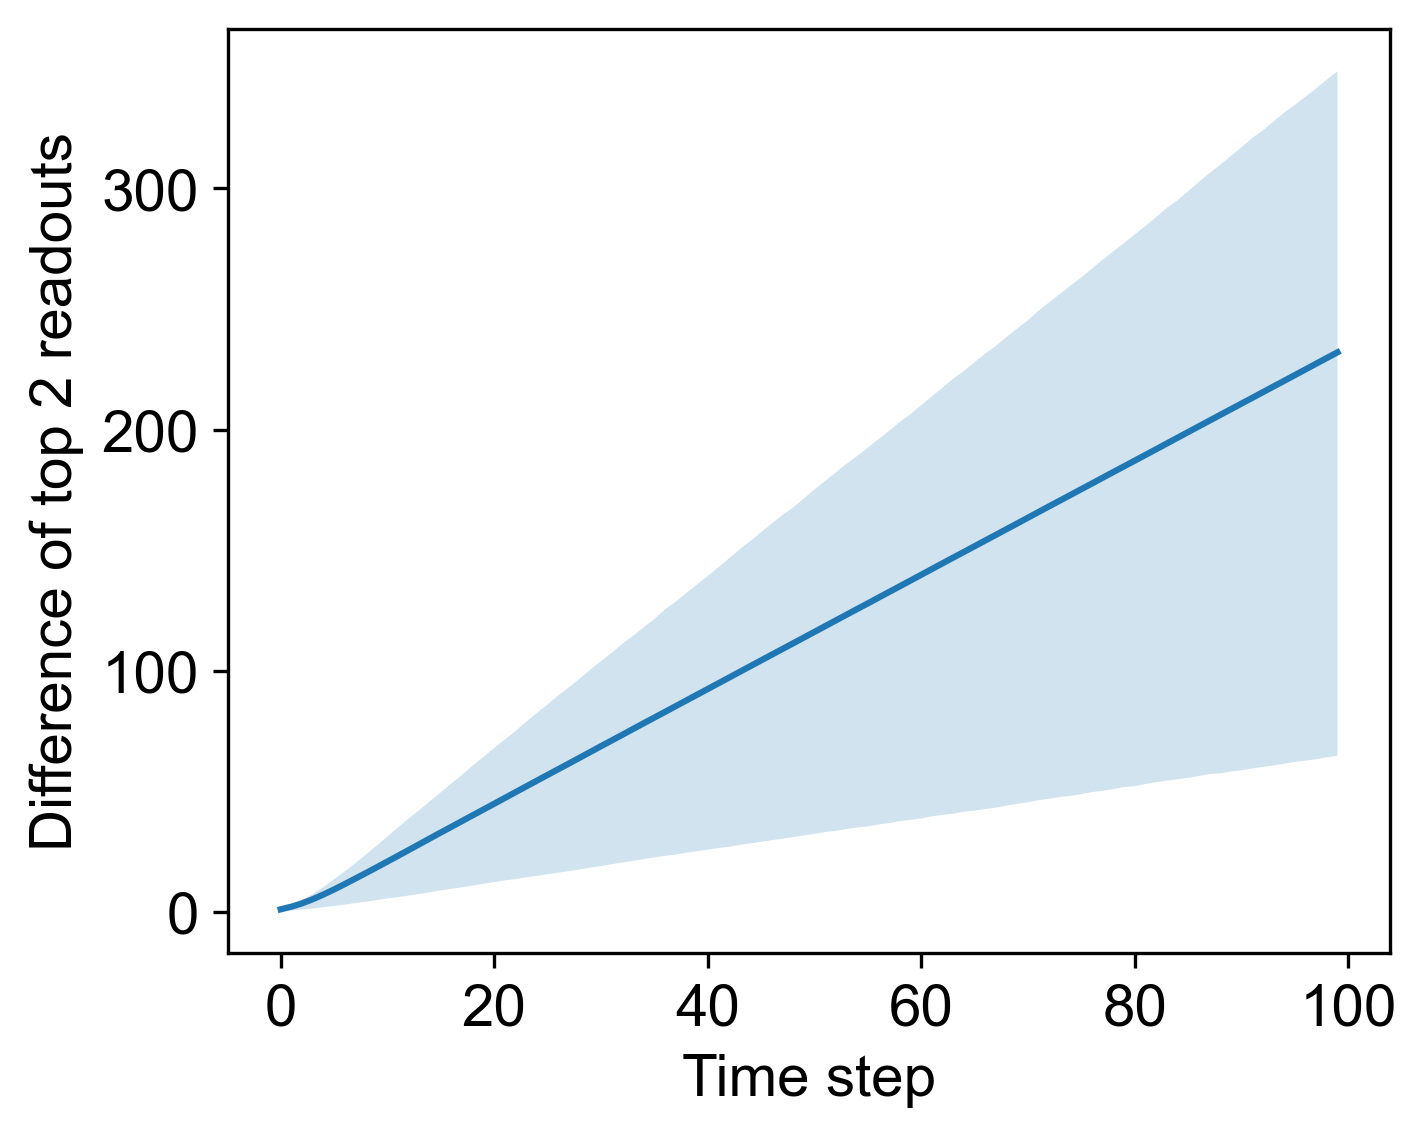

In [43]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [51]:
lb = 5
ub = 100
steps = 150
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

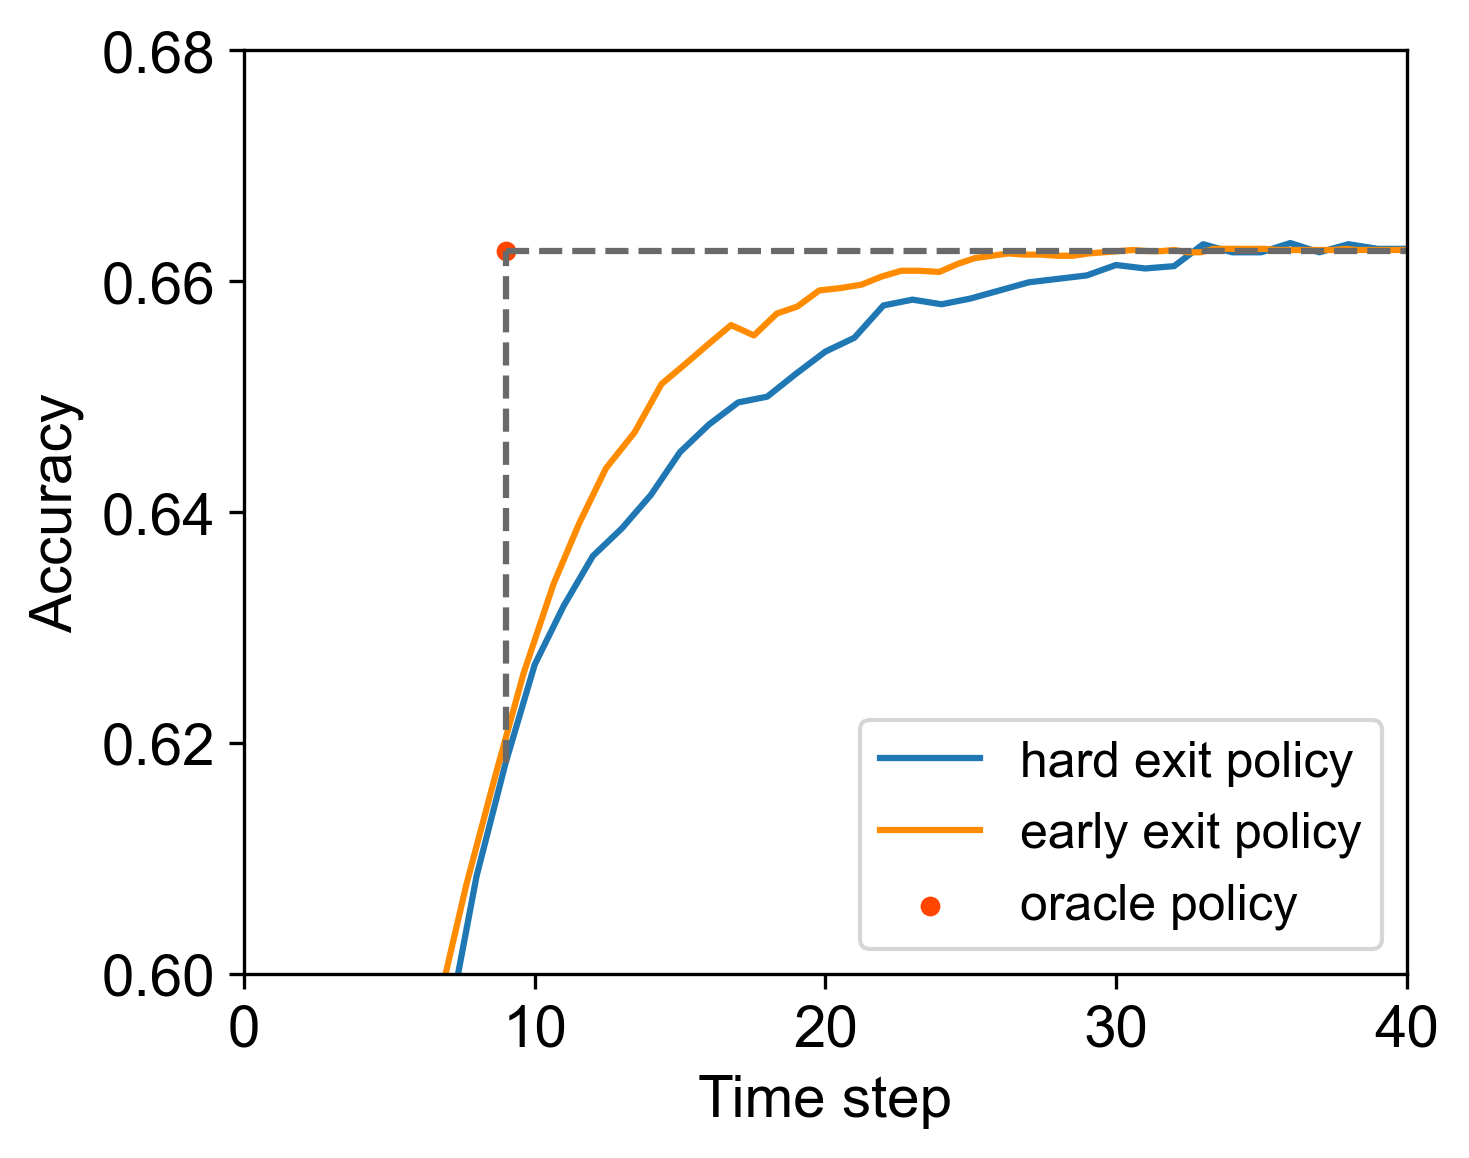

tensor(8.9960)
0.6625999808311462
[6.673399925231934, 7.643199920654297, 8.613800048828125, 9.623600006103516, 10.650400161743164, 11.524700164794922, 12.452099800109863, 13.434700012207031, 14.364800453186035, 15.169300079345703, 16.00079917907715, 16.756399154663086, 17.542999267578125, 18.33060073852539, 19.035400390625, 19.790300369262695, 20.520999908447266, 21.246000289916992, 21.936800003051758, 22.611799240112305, 23.25659942626953, 23.922800064086914, 24.559900283813477, 25.151500701904297, 25.721900939941406, 26.297000885009766, 26.83340072631836, 27.429399490356445, 27.986900329589844, 28.527599334716797, 29.057199478149414, 29.573400497436523, 30.085399627685547, 30.596500396728516, 31.096900939941406, 31.5492000579834, 32.0077018737793, 32.458499908447266, 32.924198150634766, 33.36220169067383, 33.82709884643555, 34.26470184326172, 34.67539978027344, 35.11349868774414, 35.53419876098633, 35.96310043334961, 36.34189987182617, 36.735599517822266, 37.13199996948242, 37.503799

In [52]:
zoom_in = True
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, 100], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
if zoom_in:
    ax.set_ylim(0.6, 0.68)
    ax.set_xlim(0, 40)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong{}.pdf'.format('_zoom_in' if zoom_in else ''))
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])

# ANN2SNN ImageNet

## ResNet34

In [3]:
path = '/home/zhichao/SNN_Calibration/'
name = 'resnet34'
result = torch.load(path + '{}_results.pt'.format(name), map_location='cpu')
targets = torch.load(path + '{}_targets.pt'.format(name), map_location='cpu')
print(result.shape, targets.shape)

torch.Size([256, 50000, 1000]) torch.Size([50000])


In [4]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

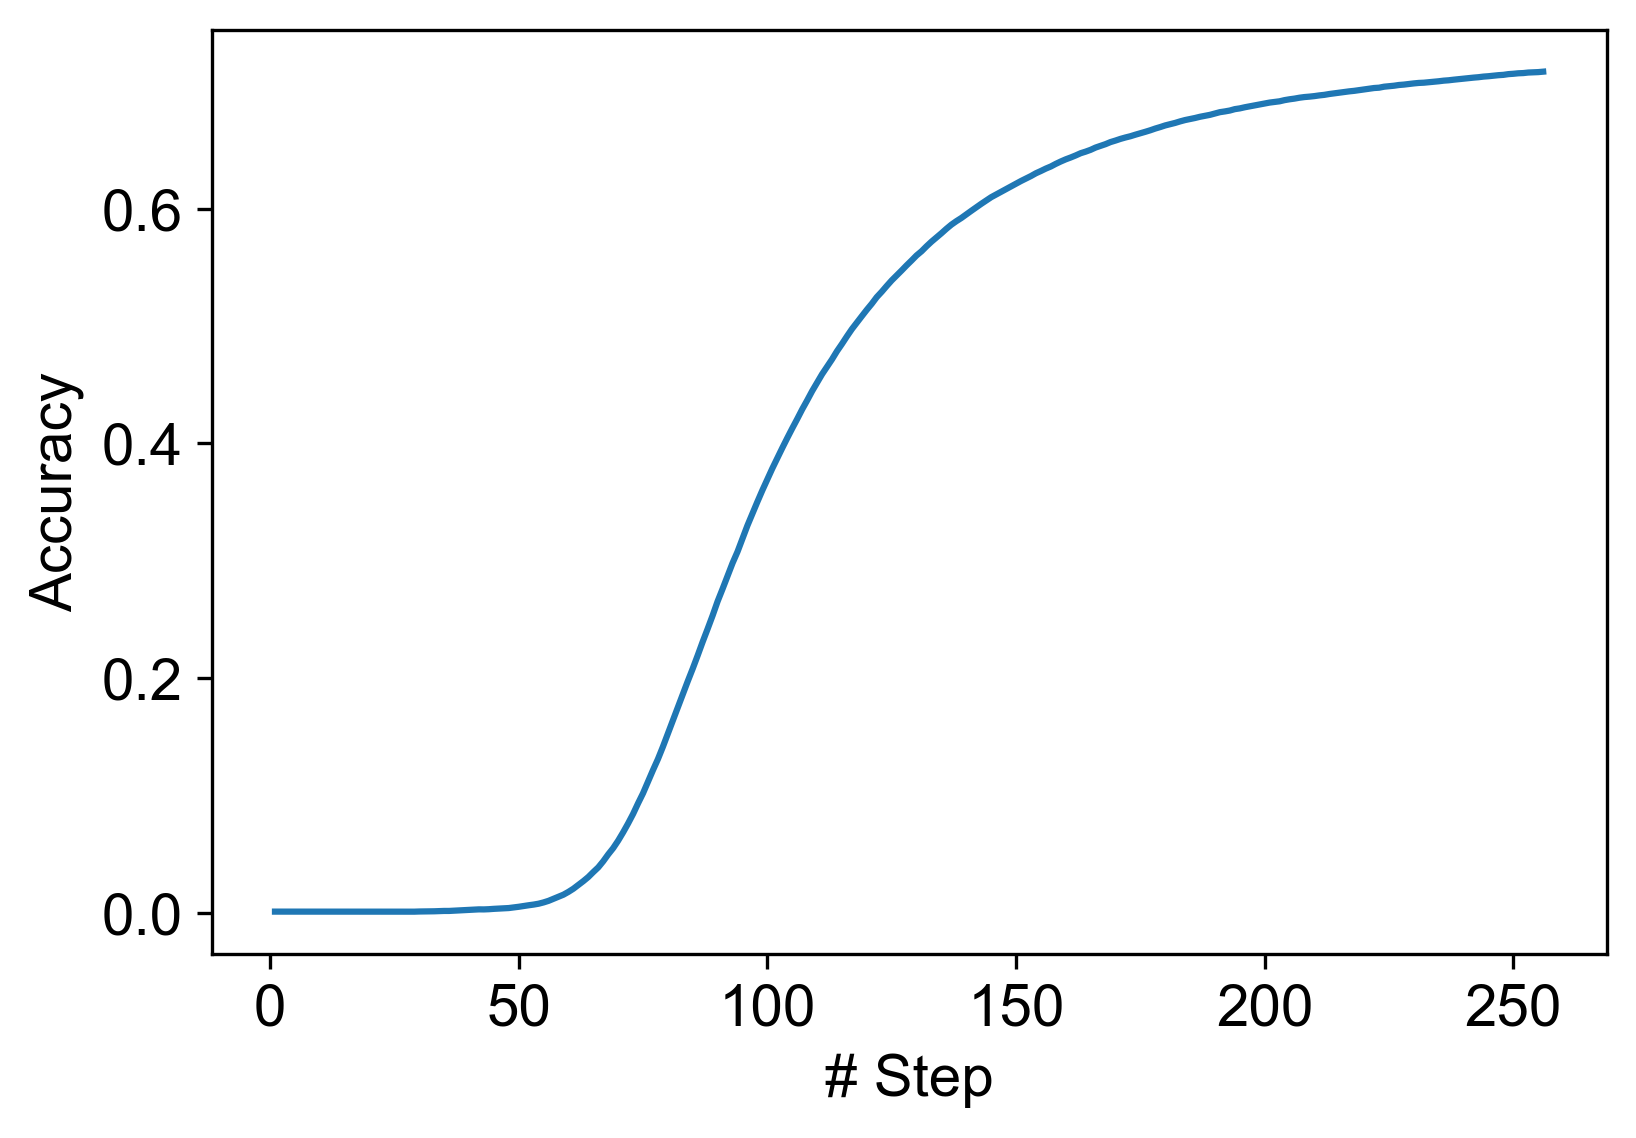

In [6]:
sim_len = running_time = 256
dt = 1
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [7]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step / torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([50000])


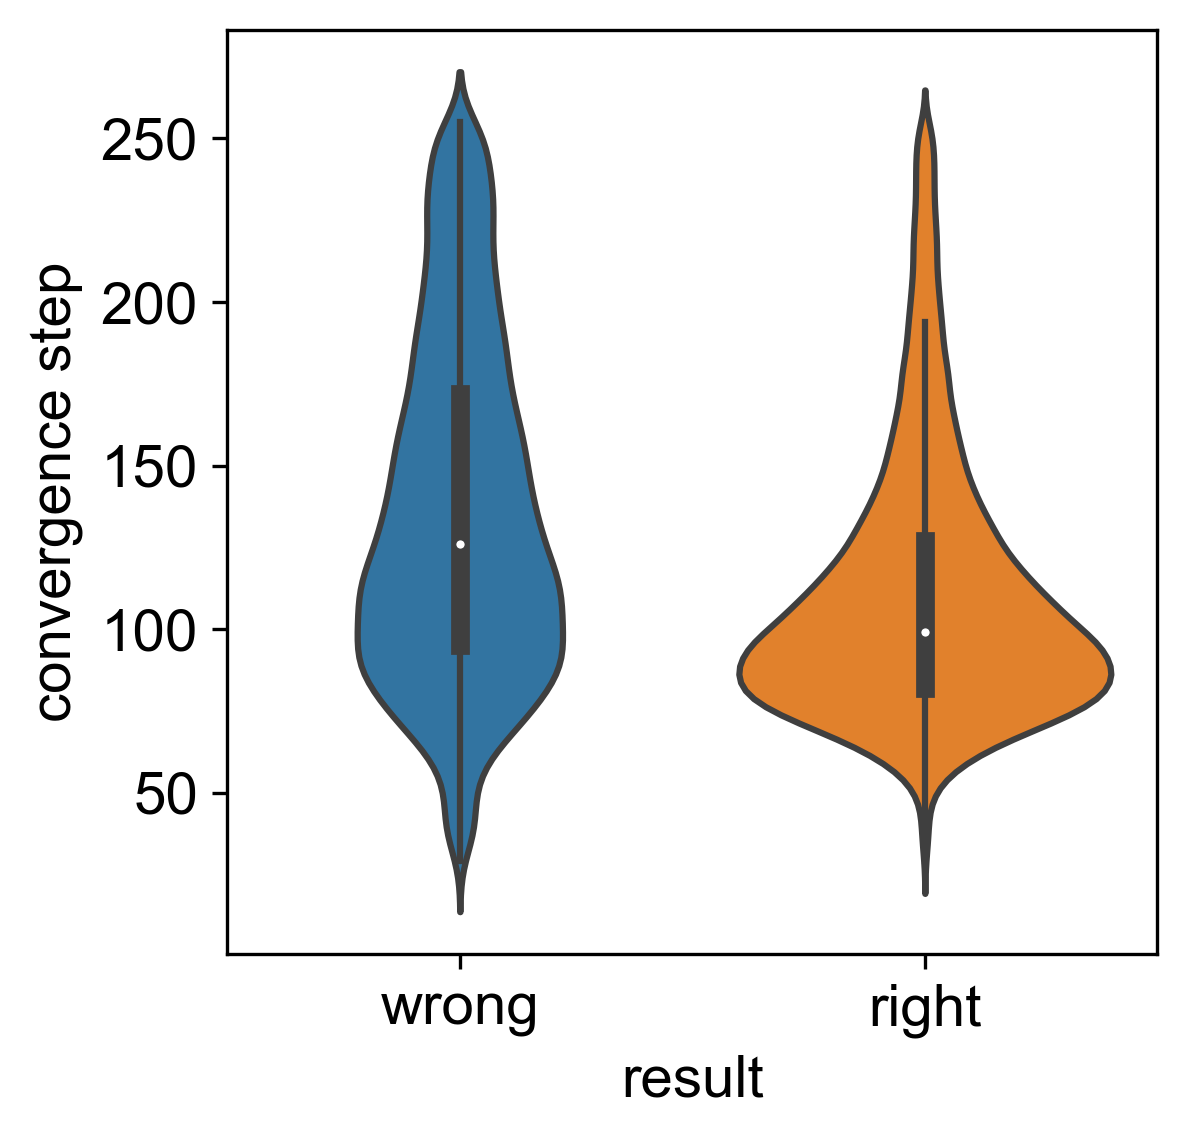

In [9]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([256, 50000])
12500 37500 torch.Size([256]) torch.Size([256])


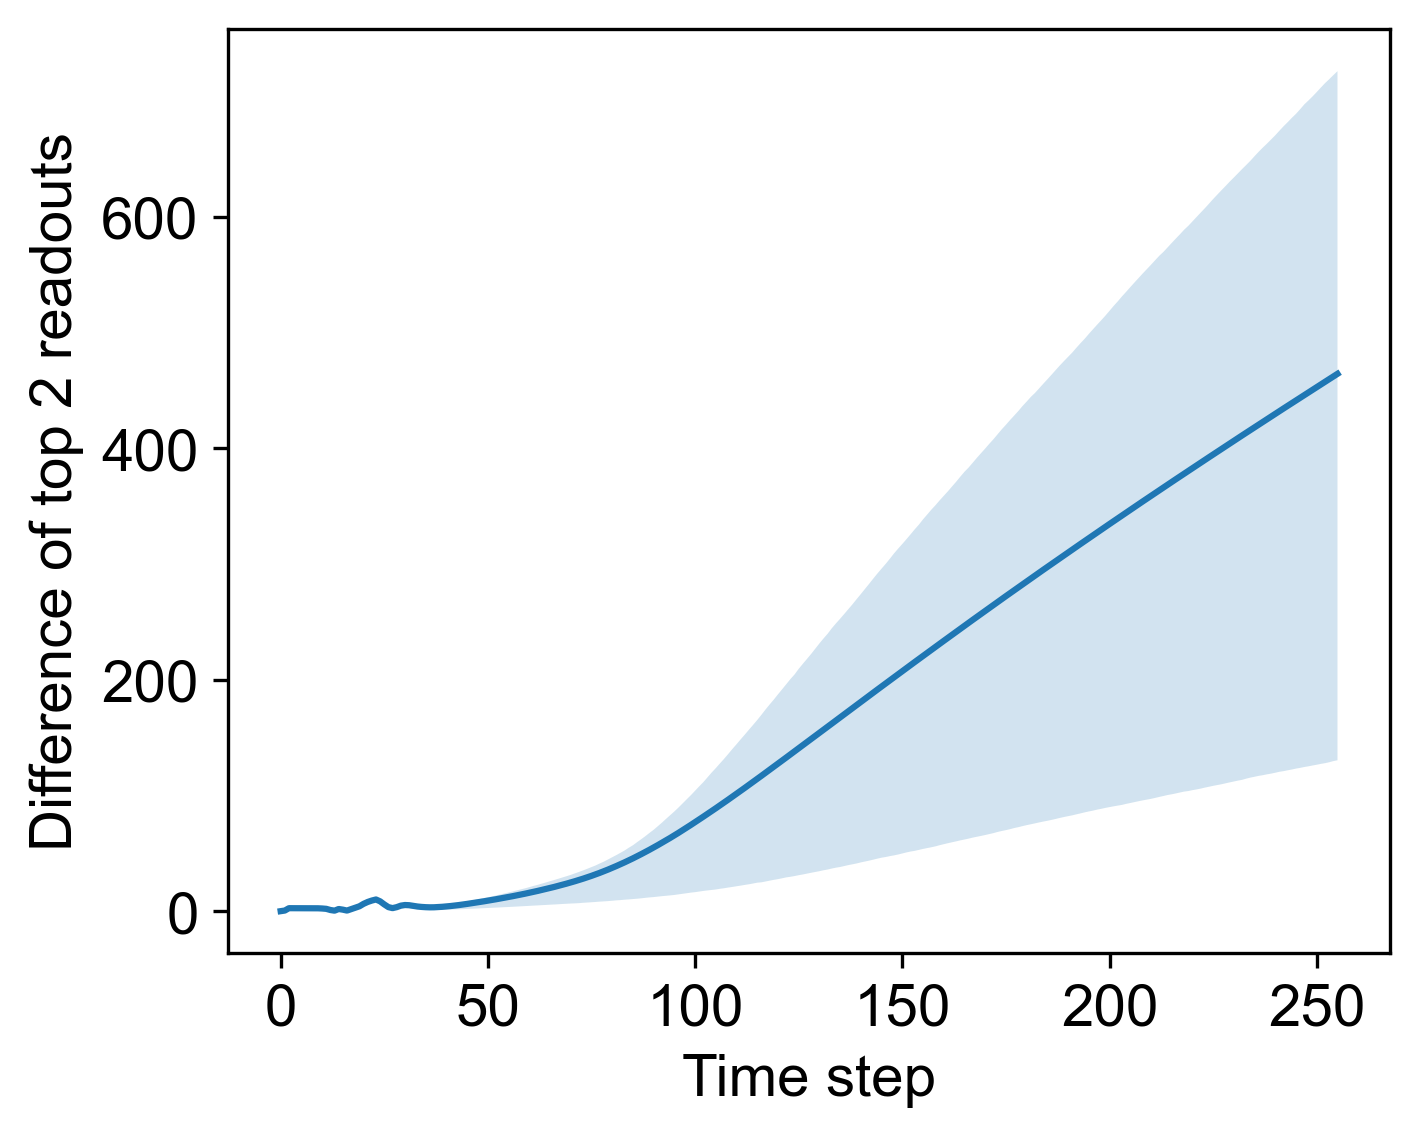

In [10]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [13]:
lb = 50
ub = 500
steps = 50
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

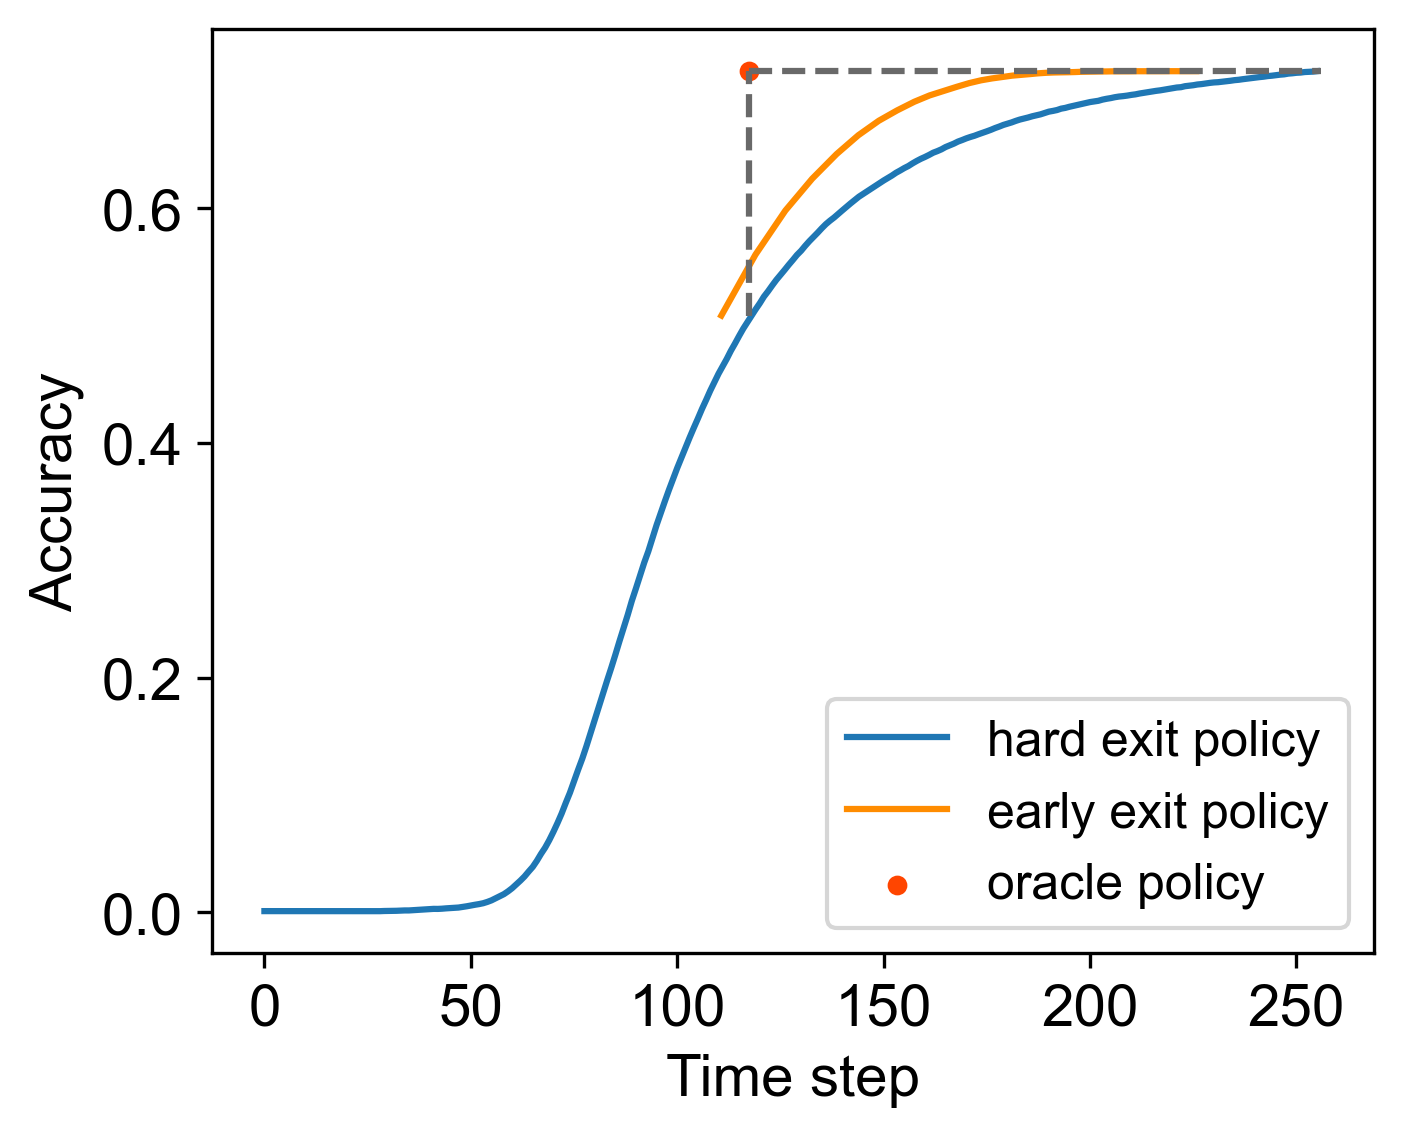

tensor(117.4540)
0.7168999910354614
[110.69322204589844, 118.93914031982422, 126.19300079345703, 132.6857452392578, 138.60110473632812, 143.8563995361328, 148.8353729248047, 153.25868225097656, 157.4217529296875, 161.12582397460938, 164.48617553710938, 167.7039031982422, 170.7267608642578, 173.5802001953125, 176.2383270263672, 178.72360229492188, 181.1083526611328, 183.31365966796875, 185.46099853515625, 187.4891357421875, 189.41734313964844, 191.28245544433594, 193.02774047851562, 194.74819946289062, 196.4227752685547, 198.05430603027344, 199.62152099609375, 201.12835693359375, 202.5984344482422, 203.99847412109375, 205.38868713378906, 206.73159790039062, 208.0463409423828, 209.31739807128906, 210.5475616455078, 211.74337768554688, 212.9156036376953, 214.06924438476562, 215.1812744140625, 216.2572784423828, 217.3065643310547, 218.33575439453125, 219.33753967285156, 220.31455993652344, 221.26974487304688, 222.2050018310547, 223.11155700683594, 224.00381469726562, 224.8744659423828, 225

In [19]:
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, sim_len], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
#ax.set_ylim(0.6, 0.68)
#ax.set_xlim(0, 40)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong.pdf')
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])

## VGG16BN

In [4]:
path = '/home/zhichao/SNN_Calibration/'
name = 'vgg16bn'
result = torch.load(path + '{}_results.pt'.format(name), map_location='cpu')
targets = torch.load(path + '{}_targets.pt'.format(name), map_location='cpu')
print(result.shape, targets.shape)

torch.Size([256, 50000, 1000]) torch.Size([50000])


In [5]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

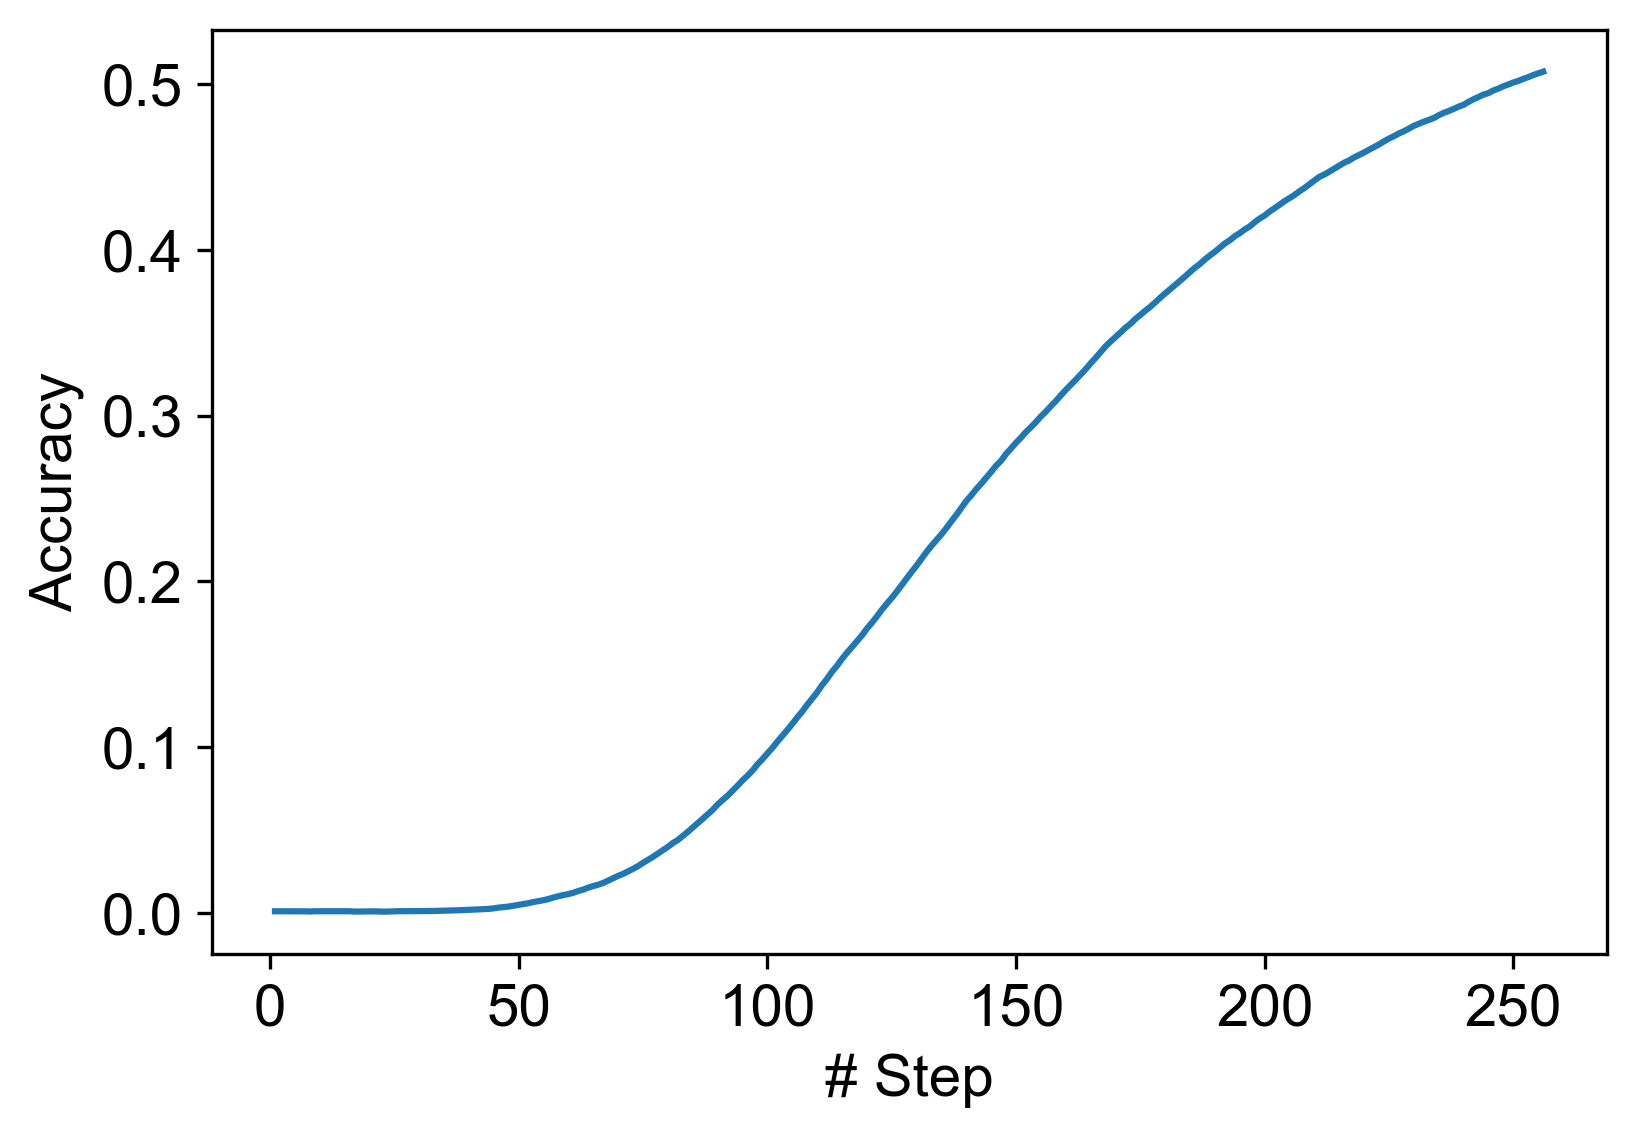

In [6]:
sim_len = running_time = 256
dt = 1
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [7]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step / torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([50000])


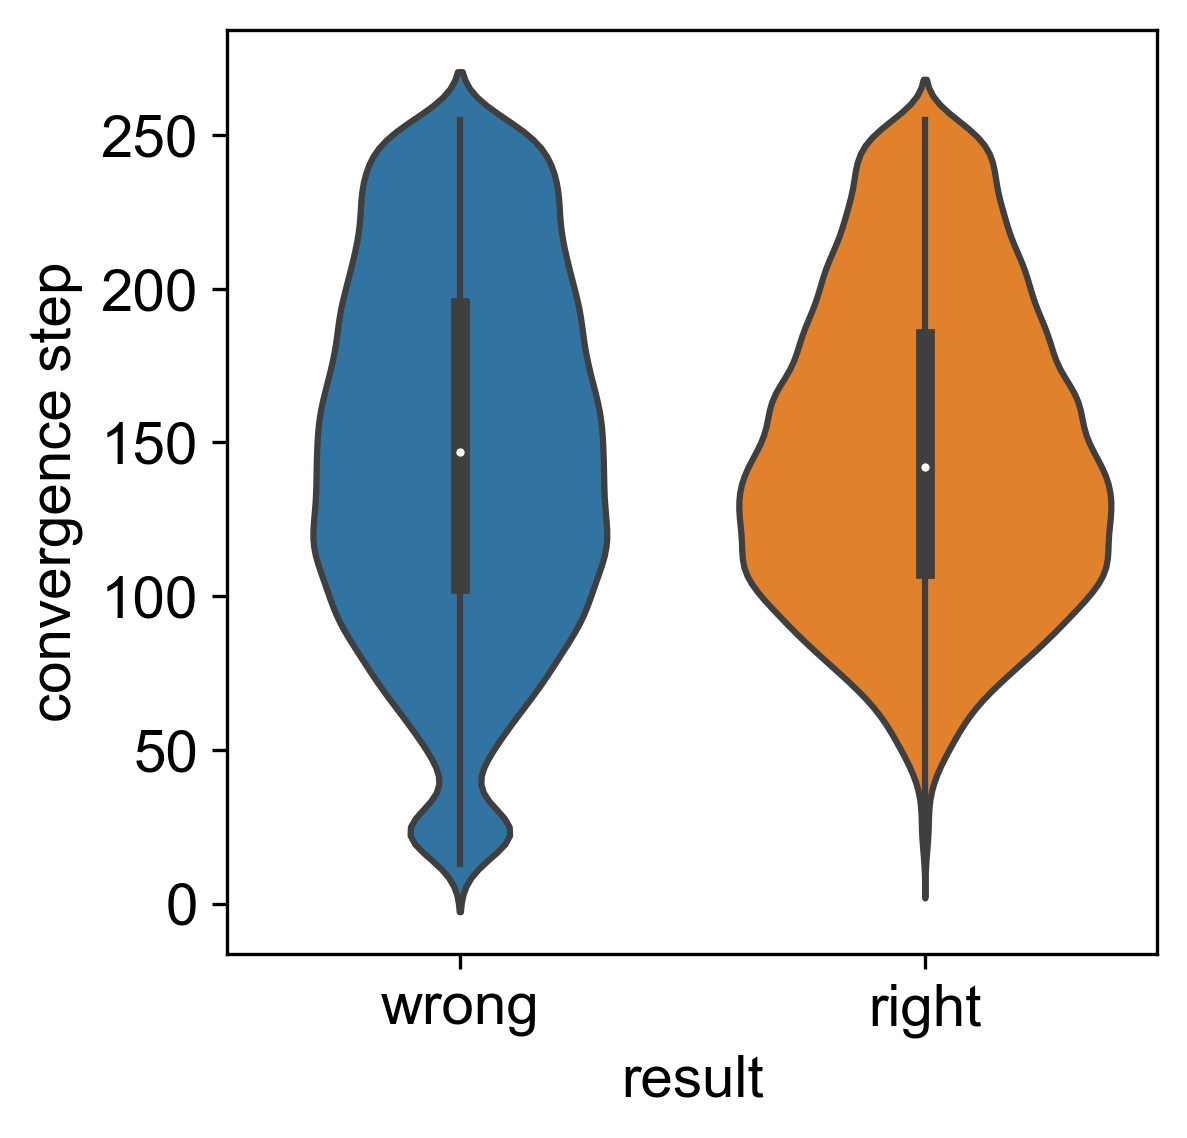

In [8]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([256, 50000])
12500 37500 torch.Size([256]) torch.Size([256])


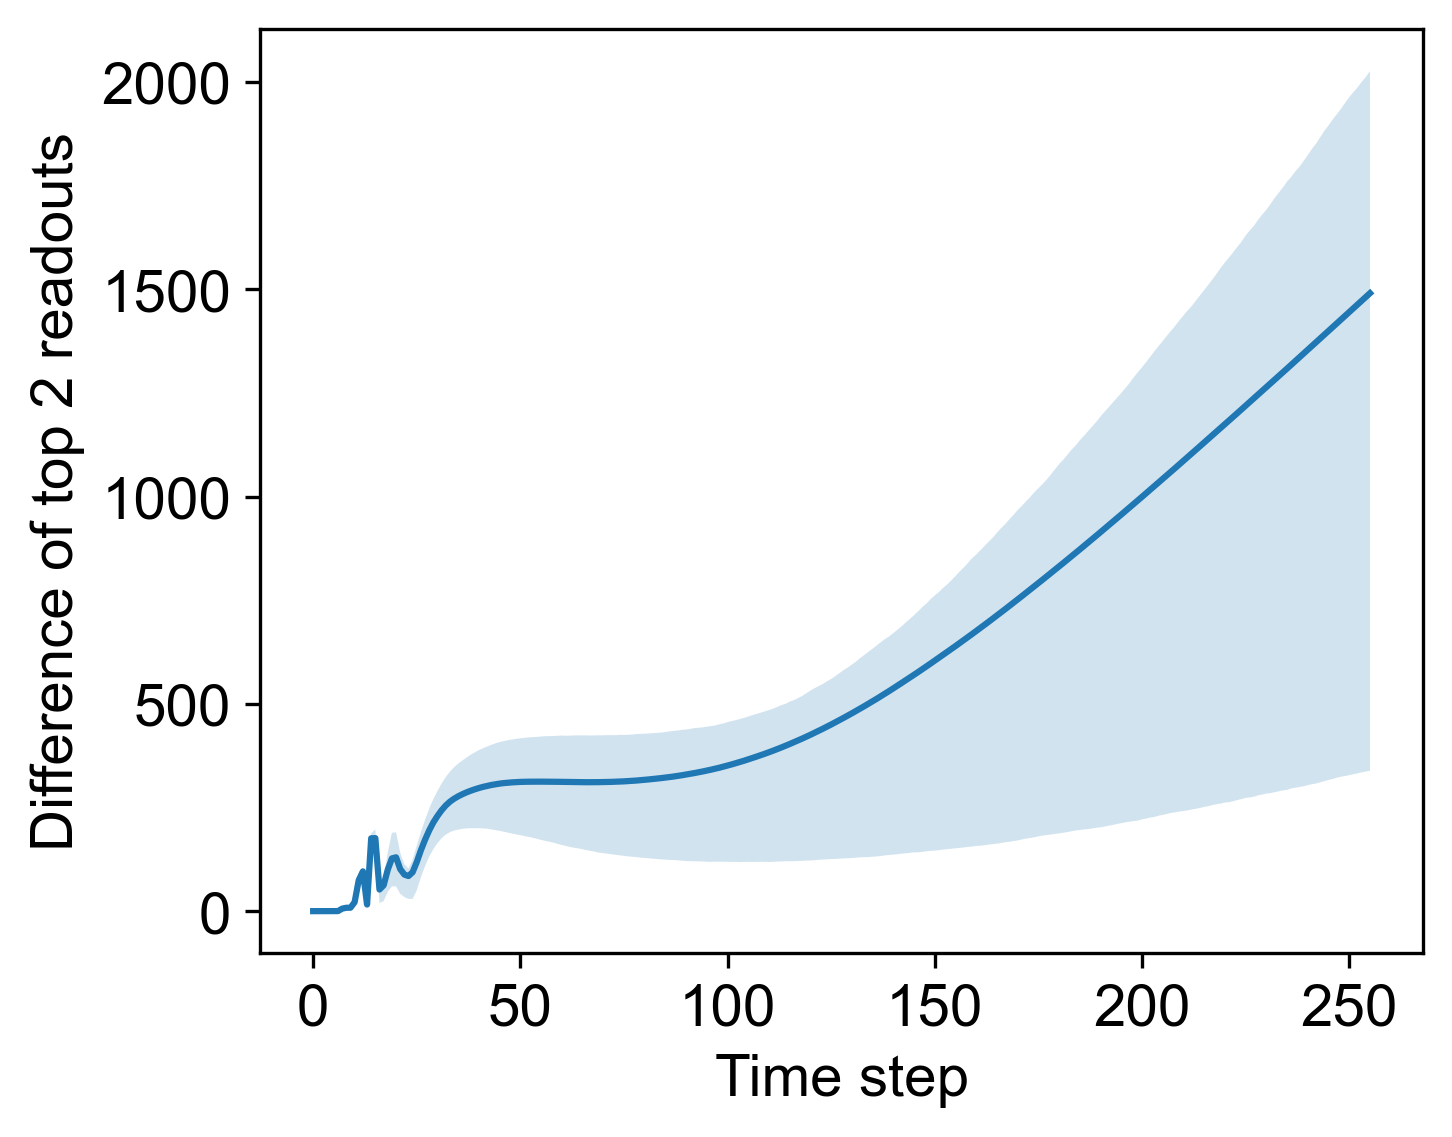

In [9]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [12]:
lb = 500
ub = 1500
steps = 50
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

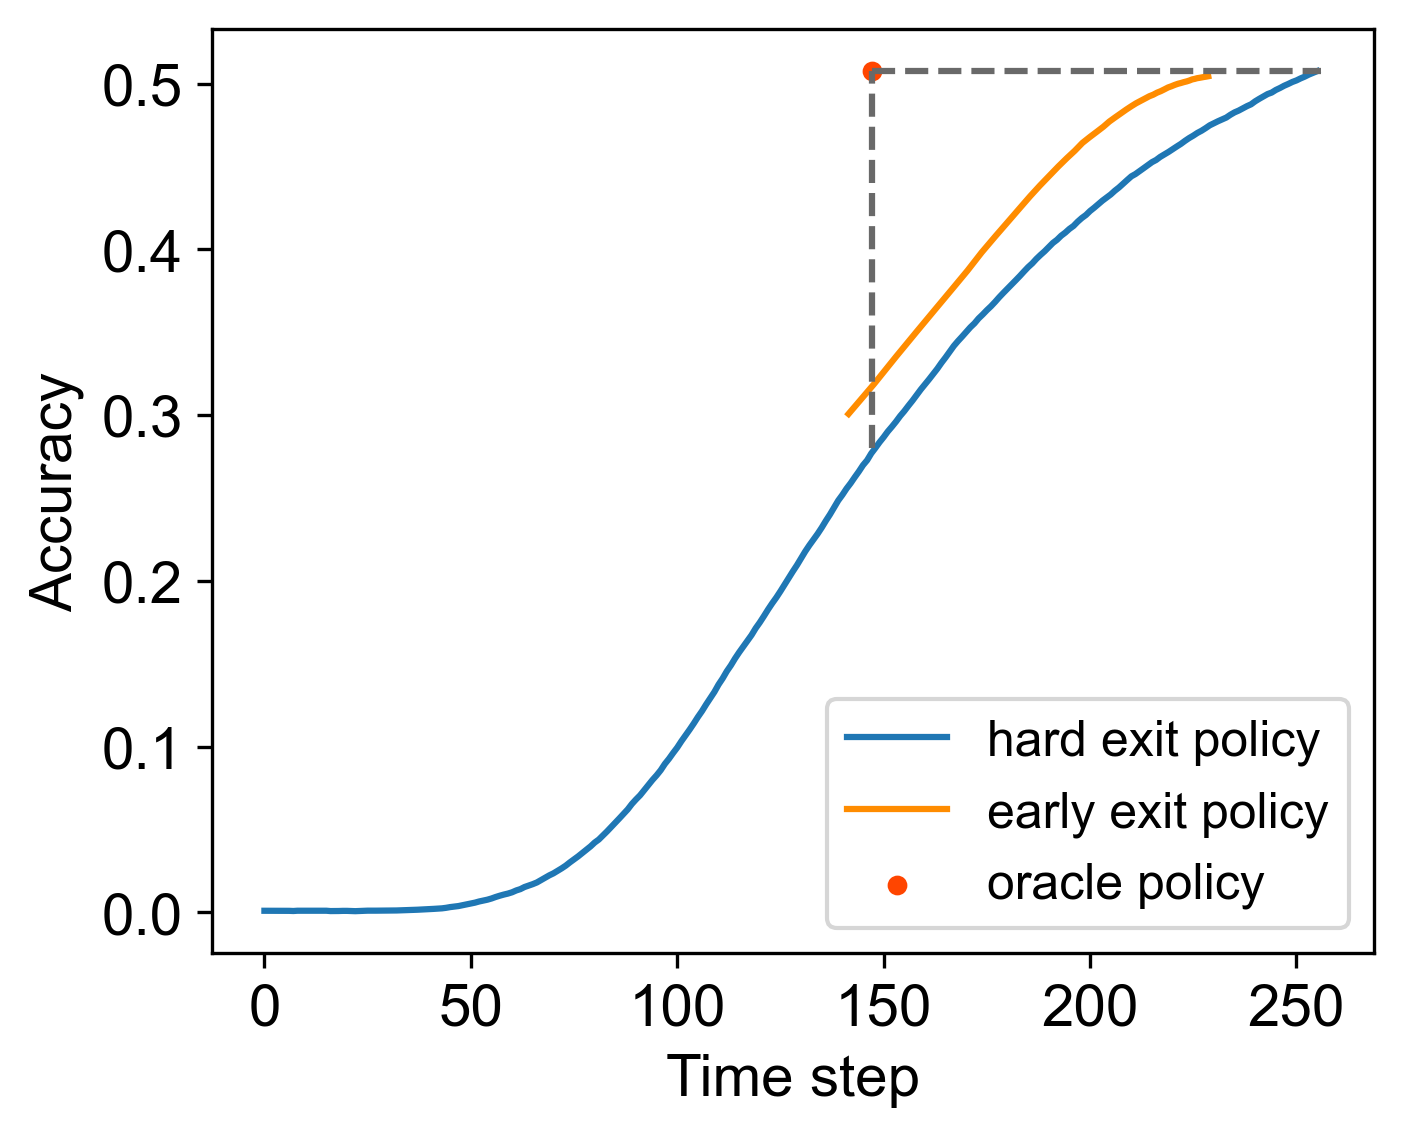

tensor(147.2158)
0.5075200200080872
[141.49639892578125, 147.651123046875, 153.0378875732422, 157.9932403564453, 162.55288696289062, 166.62551879882812, 170.31455993652344, 173.75892639160156, 177.07164001464844, 180.13186645507812, 182.83799743652344, 185.47120666503906, 187.8845672607422, 190.169677734375, 192.29612731933594, 194.3961639404297, 196.2997589111328, 198.15667724609375, 199.94027709960938, 201.67495727539062, 203.22459411621094, 204.6747589111328, 206.09422302246094, 207.43580627441406, 208.70138549804688, 209.91673278808594, 211.11276245117188, 212.19927978515625, 213.2646942138672, 214.35011291503906, 215.2967987060547, 216.23501586914062, 217.12437438964844, 217.99864196777344, 218.8819580078125, 219.68722534179688, 220.51242065429688, 221.29623413085938, 222.0007781982422, 222.72412109375, 223.40203857421875, 224.04745483398438, 224.73135375976562, 225.3359375, 225.9376220703125, 226.50172424316406, 227.0673370361328, 227.6089324951172, 228.12782287597656, 228.632339

In [13]:
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, sim_len], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
#ax.set_ylim(0.6, 0.68)
#ax.set_xlim(0, 40)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong.pdf')
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])

# MNN one layer validation

In [ ]:
class CustomMnnMlp(snn.mnn2snn.MnnMlpTrans):
    def forward(self, x):
        x = self.mlp(x)
        x = torch.matmul(self.predict.weight, x.unsqueeze(-1)).squeeze(-1)
        if self.predict.bias is not None:
            x += self.predict.bias
        return x

class CustomMnnMean(snn.mnn2snn.MnnMlpMeanOnlyTrans):
    def forward(self, x):
        x = self.mlp(x)
        x = self.predict(x)
        return x

class CustomValidate(snn.functional.MnnSnnValidate):
    def generate_snn_model(self):
        model = CustomMnnMean(**self.args.MODEL)
        return model
    def generate_dataset(self):
        pass

## Poisson spike, scale factor = 0.1

In [88]:
path = './checkpoint/nips_compare_0805/'
name = 'with_covariance_0'
args = utils.training_tools.TempArgs()
args.config = path + '{}_config.yaml'.format(name)
args = utils.training_tools.set_config2args(args)
print(args.scale_factor, args.background_noise)
dt = 1.
num_trial = args.bs
running_time = 100
resume_best = True
func = snn.functional.MnnSnnValidate(args, running_time=running_time, resume_best=resume_best, dt=dt, num_trials=num_trial, input_type='poisson', MNN_MLP=CustomMnnMlp)
train_loader, test_loader = func.train_funcs.prepare_dataloader(args)
print(func.args.bs, func.num_trials)
print(func.snn)

0.1 0.0
50 50
CustomMnnMlp(
  (mlp): Sequential(
    (0): LinearDuo(
      in_features: 784, out_features: 1000, bias_mean: False, bias_var: False, dropout: False, scale: None
      (generator): GeneralCurrentGenerator()
    )
    (1): CustomBatchNorm1D(
      num_features: 1000, bias_std=False, special_init=True, momentum=0.9, eps=1e-05, affine=True
      (generator): GeneralCurrentGenerator()
    )
    (2): LIFNeurons(L: 0.05000000074505806, V_th: 20.0, V_res: 0.0, dt: 1.0, T_ref: 5.0)
  )
  (predict): LinearDuo(in_features: 1000, out_features: 10, bias_mean: False, bias_var: False, dropout: False, scale: None)
  (monitor): SpikeMonitor()
)


In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
result = []
targets = []
model = func.snn.to(device)
#test_loader.batch_size = num_trial
print(test_loader.batch_size)
with torch.no_grad():
    model.eval()
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        targets.append(labels)
        (mean, cov), _ = func.train_funcs.data2device(images, None, func.args)
        #print(mean.shape, cov.shape, mean.device, cov.device)
        #break
        assert torch.max(mean) <= func.args.scale_factor
        input_current = snn.base.PoissonSpikeGenerator(
            num_neurons=(images.shape[0], 784),
            freqs=mean.squeeze(),
            dt=func.dt
        ).cuda(func.args.local_rank)
        case = []
        for _ in range(int(running_time / dt)):
            x = input_current()
            x = model(x)
            case.append(x.unsqueeze(0))
        model.reset()
        case = torch.cat(case, dim=0).cpu()
        result.append(case)
    result = torch.cat(result, dim=1)
    targets = torch.cat(targets, dim=0)
    print(result.shape, targets.shape)

50


100%|██████████| 200/200 [00:19<00:00, 10.22it/s]

torch.Size([100, 10000, 10]) torch.Size([10000])


In [90]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

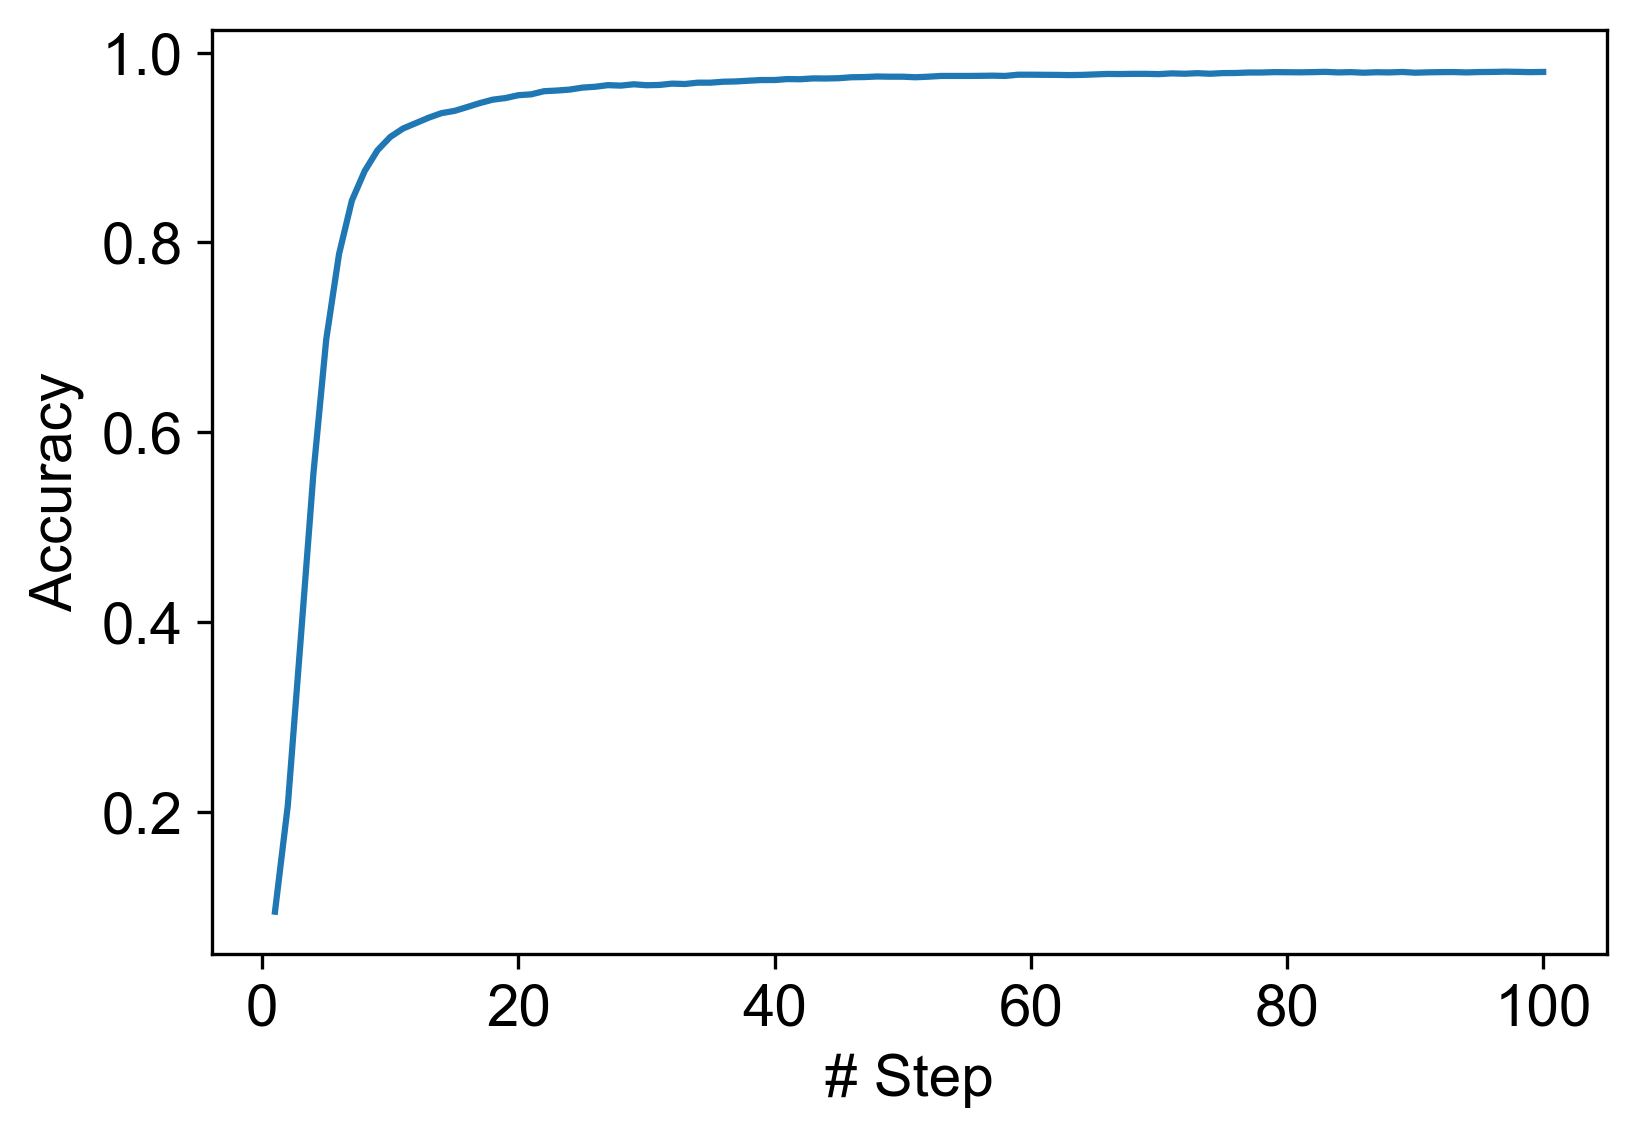

In [91]:
sim_len = running_time
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [92]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step / torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([10000])


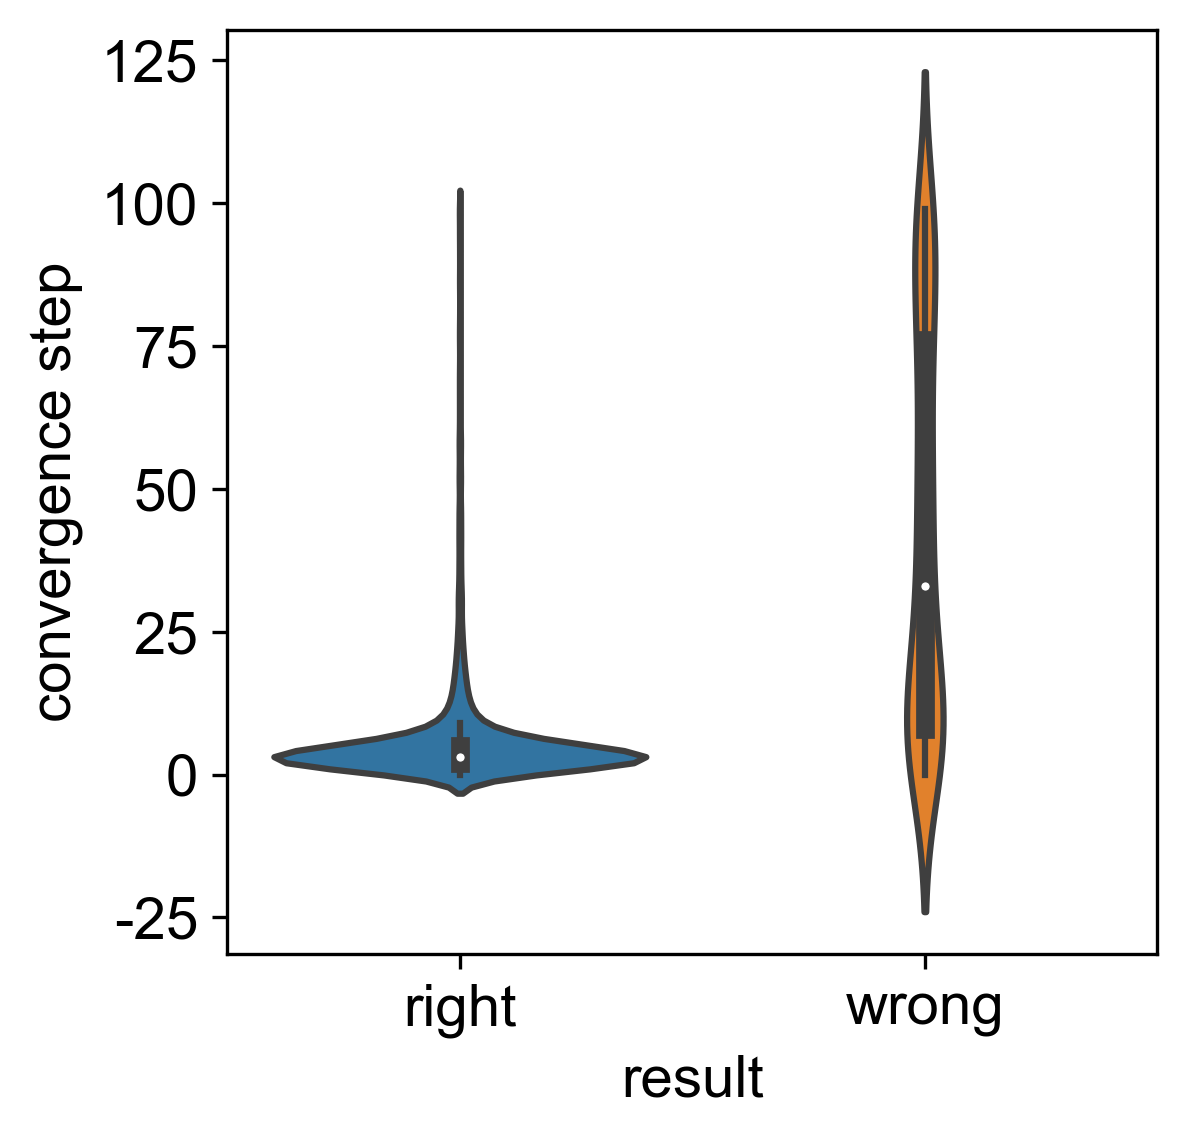

In [93]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([100, 10000])
2500 7500 torch.Size([100]) torch.Size([100])


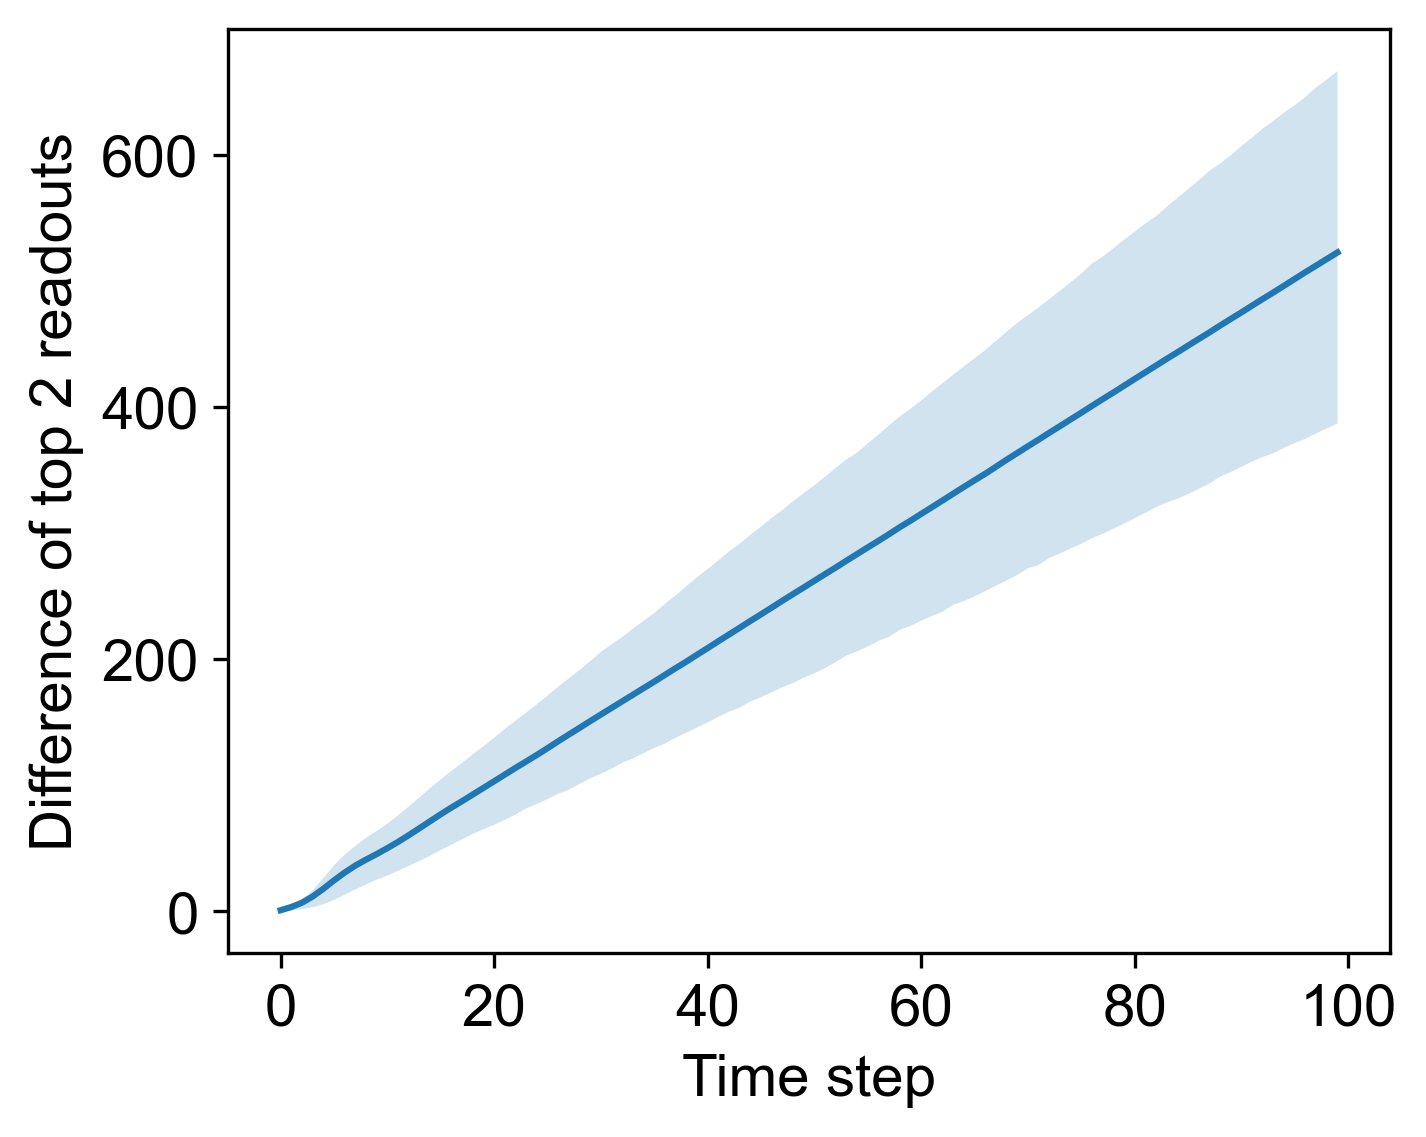

In [94]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [95]:
lb = 20
ub = 300
steps = 50
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

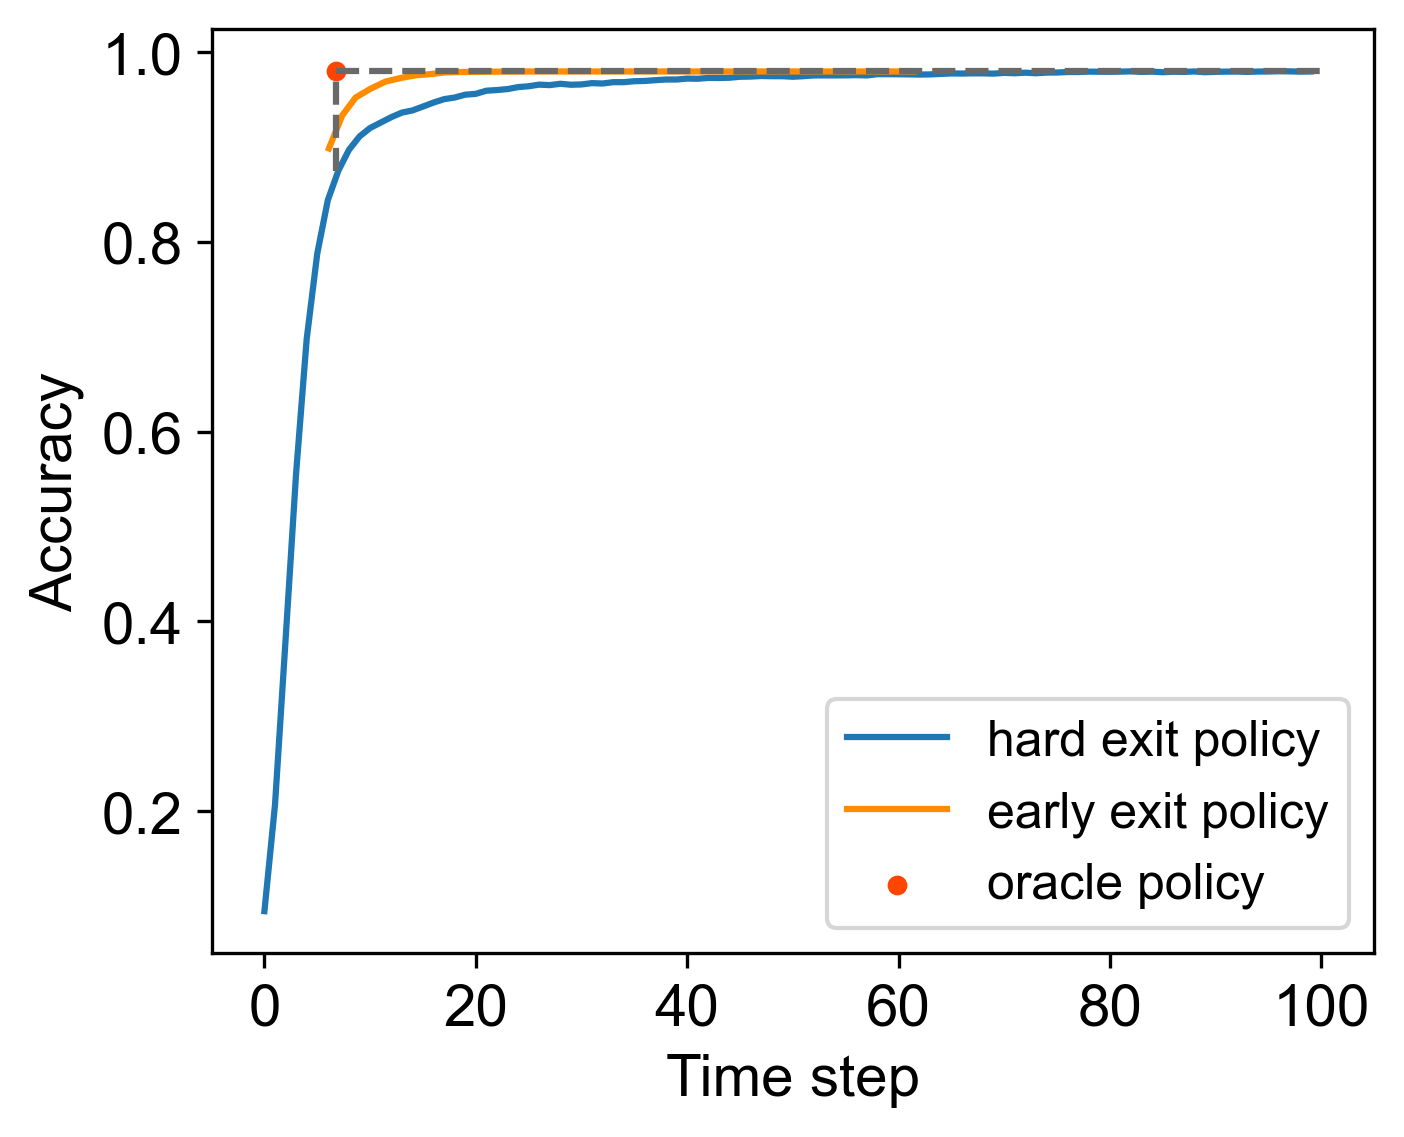

tensor(6.7449)
0.9797000288963318
[6.105299949645996, 7.367000102996826, 8.62720012664795, 10.026599884033203, 11.447600364685059, 12.851300239562988, 14.34630012512207, 15.715299606323242, 17.131900787353516, 18.54010009765625, 19.877399444580078, 21.175500869750977, 22.453699111938477, 23.693199157714844, 24.952499389648438, 26.137300491333008, 27.325700759887695, 28.524099349975586, 29.66080093383789, 30.83970069885254, 32.02299880981445, 33.186798095703125, 34.3119010925293, 35.46670150756836, 36.56420135498047, 37.663299560546875, 38.7401008605957, 39.81919860839844, 40.938201904296875, 42.03620147705078, 43.07109832763672, 44.12459945678711, 45.136600494384766, 46.19110107421875, 47.25270080566406, 48.29560089111328, 49.31290054321289, 50.298301696777344, 51.27119827270508, 52.2327995300293, 53.18109893798828, 54.138301849365234, 55.09939956665039, 55.99290084838867, 56.89670181274414, 57.80739974975586, 58.71580123901367, 59.64939880371094, 60.554100036621094, 61.42399978637695]

In [96]:
zoom_in = False
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, 100], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
if zoom_in:
    ax.set_ylim(0.8, 1.)
    ax.set_xlim(0, 40)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong{}.pdf'.format('_zoom_in' if zoom_in else ''))
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])

## Scale = 1, constant input

In [11]:
class MeanOnlyTrain(utils.training_tools.general_train.TrainProcessCollections):
    def make_model(self, args):
        model = models.MnnMlpMeanOnly(**args.MODEL)
        return model

class CustomMnnMean(snn.mnn2snn.MnnMlpMeanOnlyTrans):
    def forward(self, x):
        x = self.mlp(x)
        x = self.predict(x)
        return x

class CustomValidate(snn.functional.MnnSnnValidate):
    def generate_snn_model(self):
        model = CustomMnnMean(**self.args.MODEL)
        return model
    def generate_dataset(self):
        pass

class MeanOnlyTrain(utils.training_tools.TrainProcessCollections):
    def make_model(self, args):
        model = models.MnnMlpMeanOnly(**args.MODEL)
        return model

In [53]:
path = './checkpoint/nips_compare_0805/'
name = 'mean_only_1'
args = utils.training_tools.TempArgs()
args.config = path + '{}_config.yaml'.format(name)
args = utils.training_tools.set_config2args(args)
print(args.scale_factor, args.background_noise)
dt = 1
num_trial = args.bs
running_time = 100
resume_best = True

func = CustomValidate(args, running_time=running_time, resume_best=resume_best, dt=dt, num_trials=num_trial, input_type='poisson',  train_funcs=MeanOnlyTrain())
train_loader, test_loader = func.train_funcs.prepare_dataloader(func.args)
print(func.args.bs, func.num_trials)
print(func.snn)

1.0 0.0
50 50
CustomMnnMean(
  (mlp): Sequential(
    (0): Linear(
      in_features=784, out_features=1000, bias=False
      (generator): GeneralCurrentGenerator()
    )
    (1): BatchNorm1d(
      1000, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True
      (generator): GeneralCurrentGenerator()
    )
    (2): LIFNeurons(L: 0.05000000074505806, V_th: 20.0, V_res: 0.0, dt: 1.0, T_ref: 5.0)
  )
  (predict): Linear(in_features=1000, out_features=10, bias=False)
  (monitor): SpikeMonitor()
)


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
result = []
targets = []
model = func.snn.to(device)
#test_loader.batch_size = num_trial
print(test_loader.batch_size)
with torch.no_grad():
    model.eval()
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        targets.append(labels)
        mean, _ = func.train_funcs.data2device(images, None, func.args)
        #print(mean.shape, cov.shape, mean.device, cov.device)
        #break
        assert torch.max(mean) <= func.args.scale_factor
        input_current = snn.base.ConstantCurrent(
            mean.squeeze(),
            dt
        ).cuda(func.args.local_rank)
        case = []
        for _ in range(int(running_time / dt)):
            x = input_current()
            x = model(x)
            case.append(x.unsqueeze(0))
        model.reset()
        case = torch.cat(case, dim=0).cpu()
        result.append(case)
    result = torch.cat(result, dim=1)
    targets = torch.cat(targets, dim=0)
    print(result.shape, targets.shape)

50


100%|██████████| 200/200 [00:15<00:00, 12.90it/s]

torch.Size([100, 10000, 10]) torch.Size([10000])


In [55]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

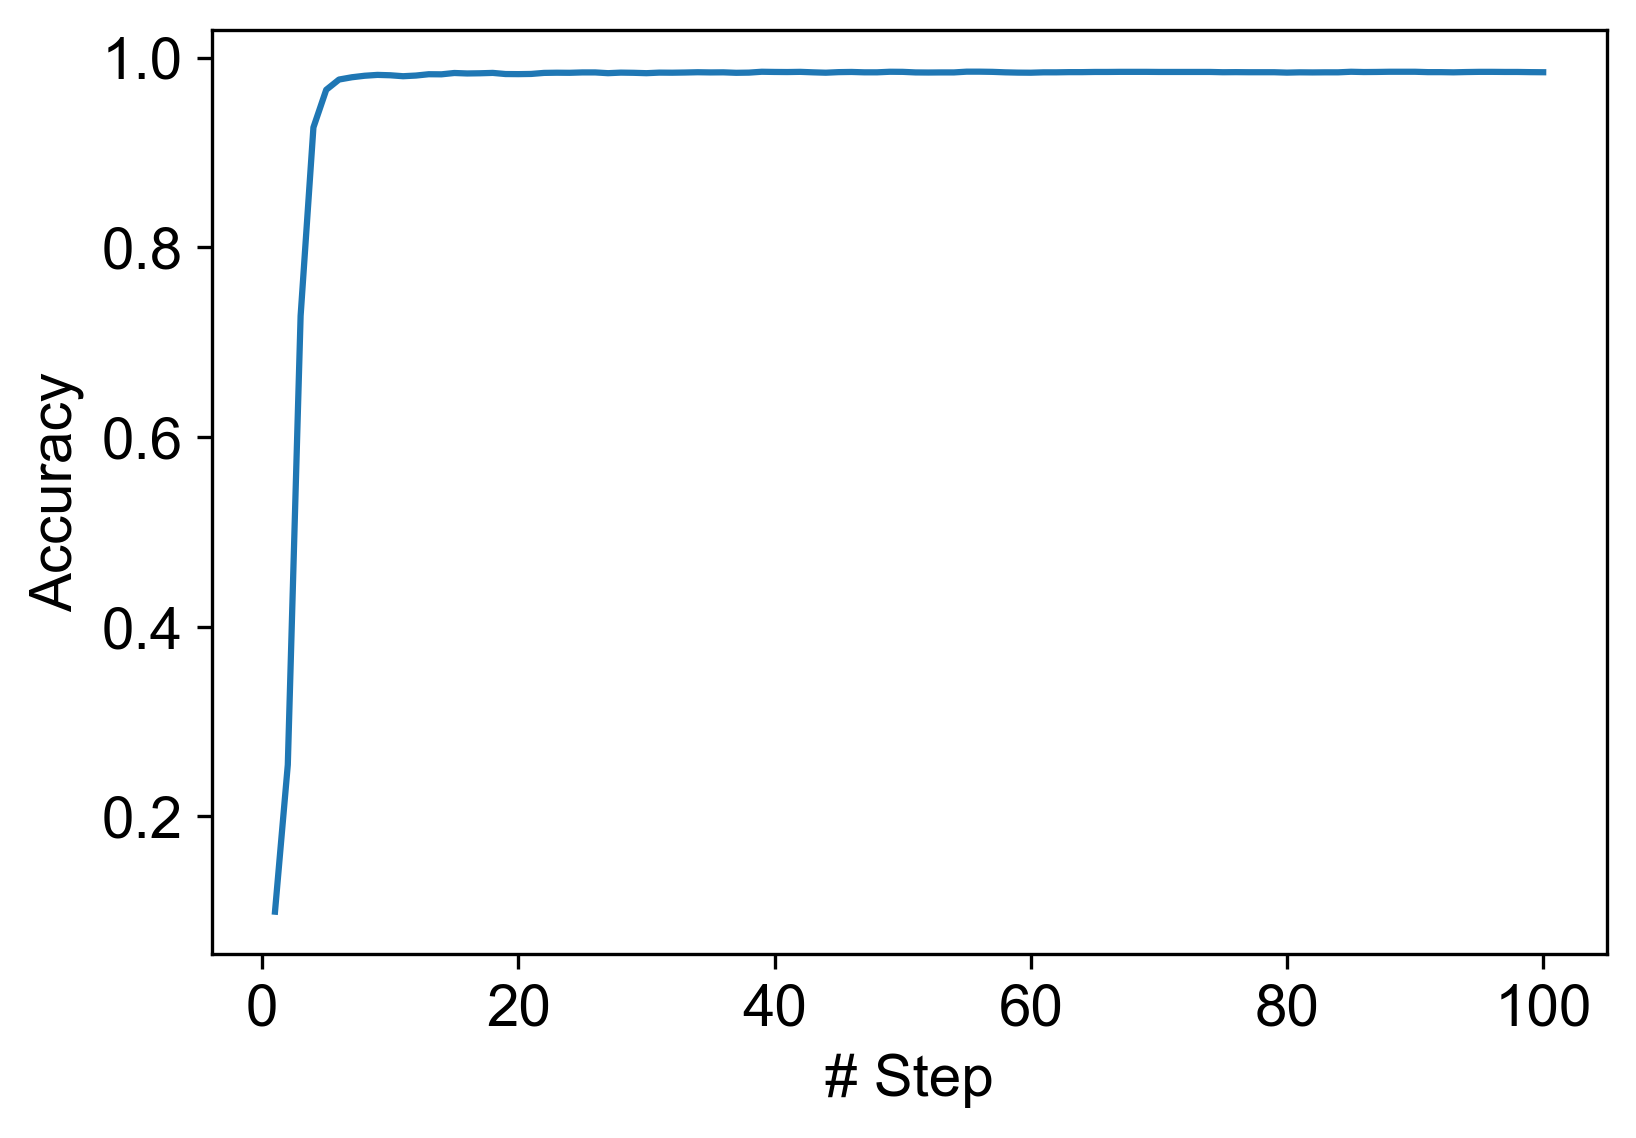

In [56]:
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [57]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step / torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([10000])


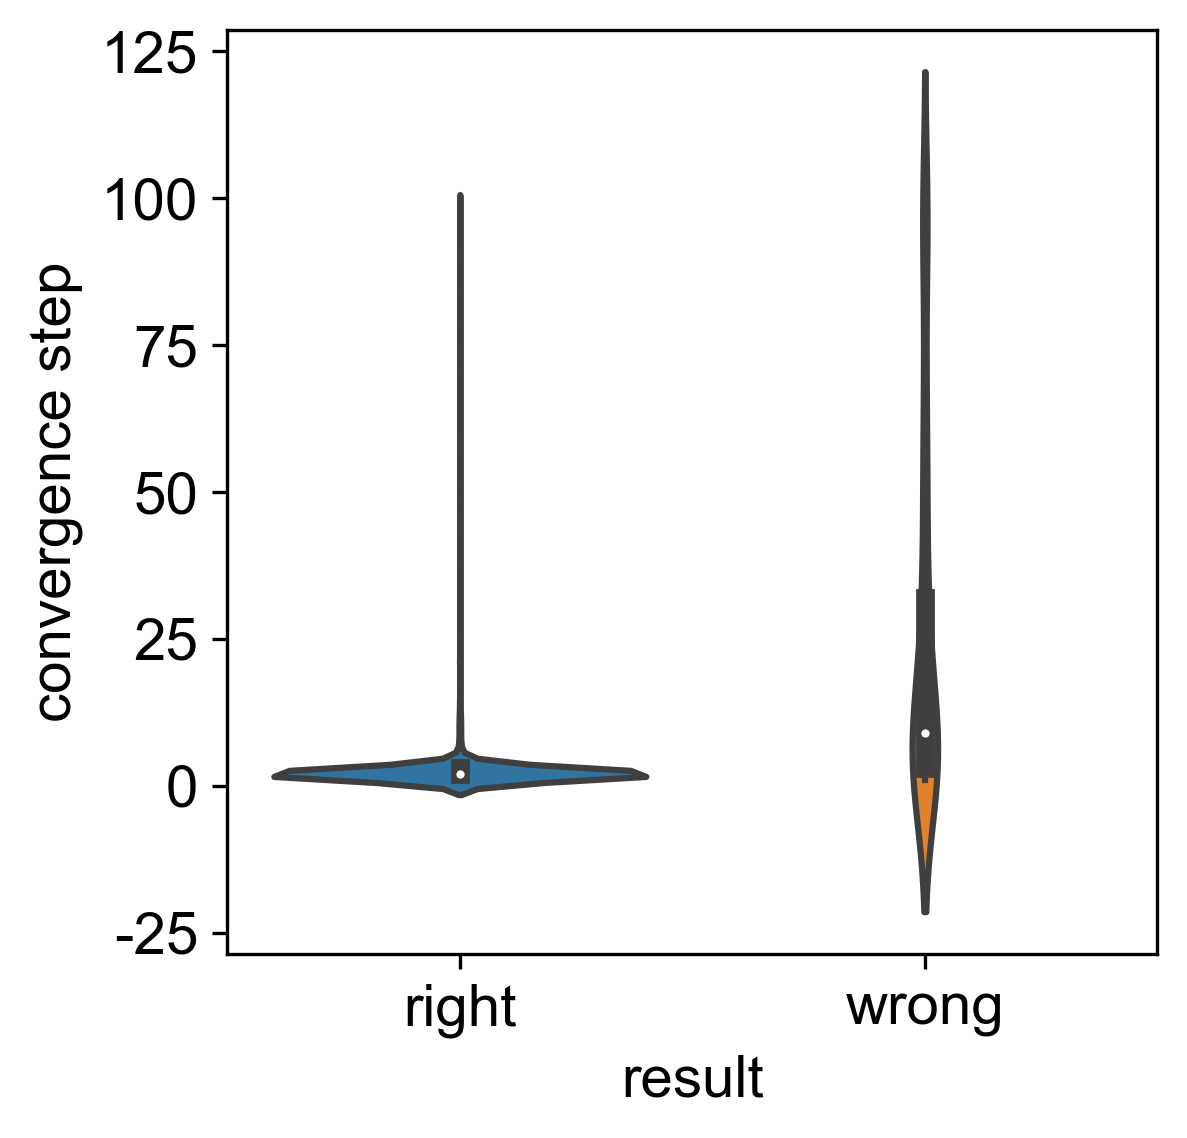

In [58]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([100, 10000])
2500 7500 torch.Size([100]) torch.Size([100])


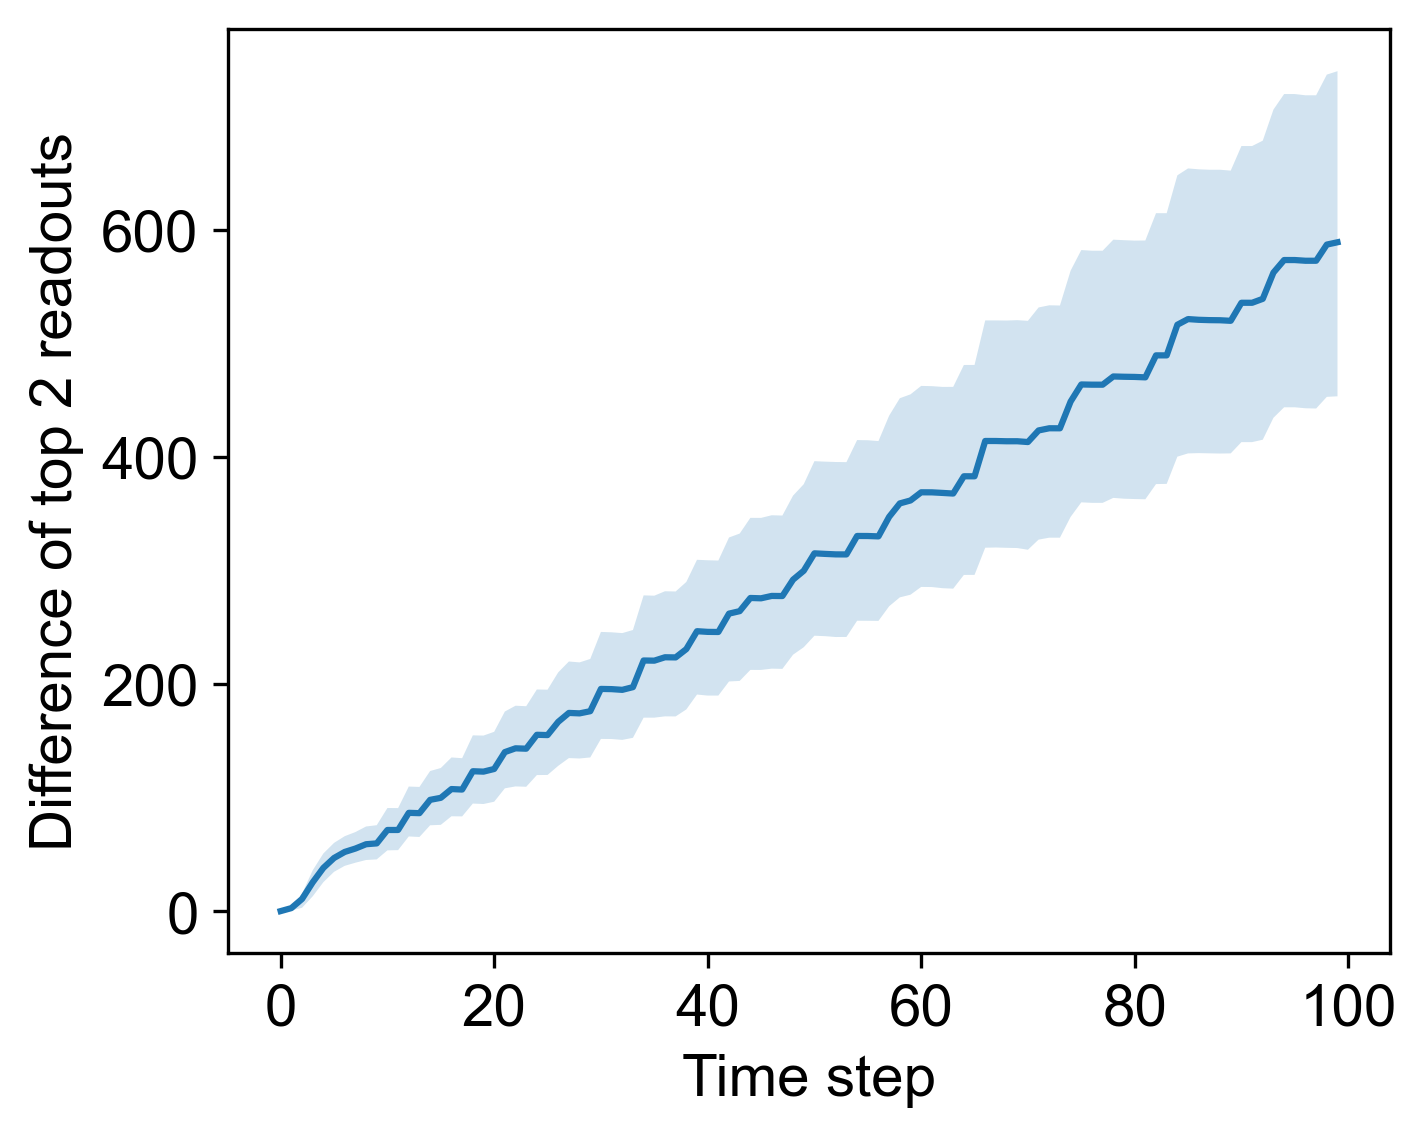

In [59]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [60]:
lb = 10
ub = 200
steps = 150
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

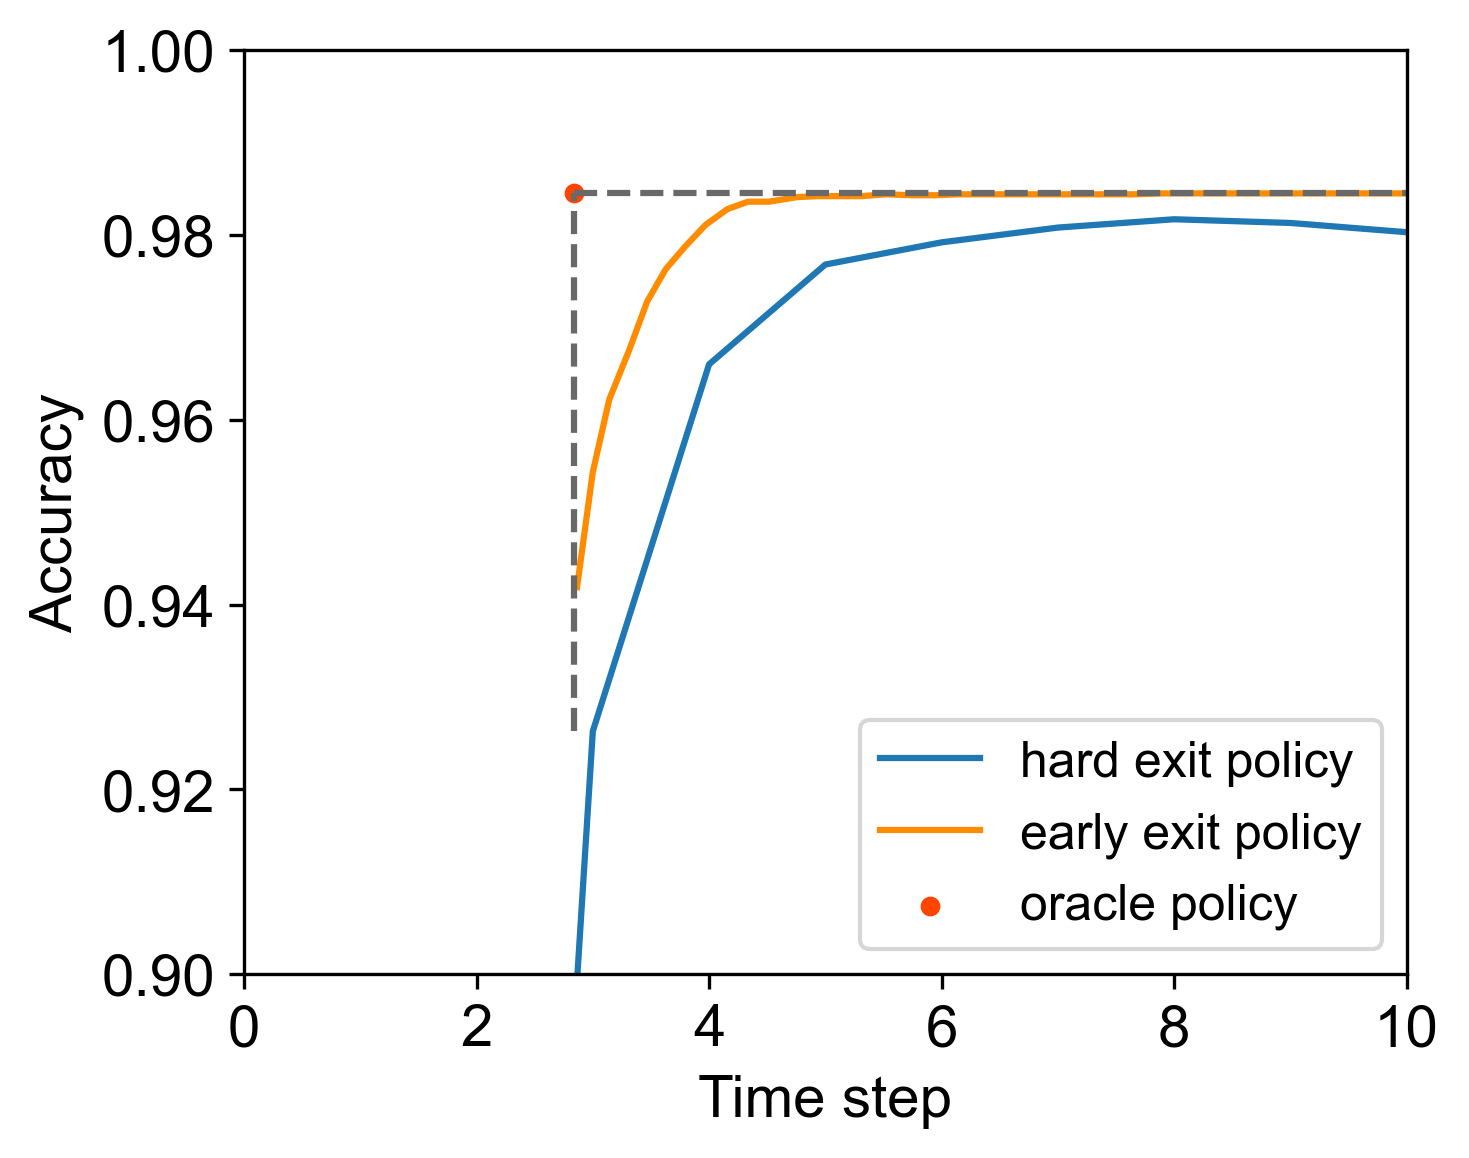

tensor(2.8405)
0.984499990940094
[2.864500045776367, 2.9990999698638916, 3.1414999961853027, 3.311500072479248, 3.4674999713897705, 3.627000093460083, 3.7976999282836914, 3.9707000255584717, 4.157899856567383, 4.335100173950195, 4.514999866485596, 4.760900020599365, 4.935999870300293, 5.111700057983398, 5.3094000816345215, 5.521999835968018, 5.741199970245361, 5.951200008392334, 6.145699977874756, 6.3709001541137695, 6.581600189208984, 6.777299880981445, 6.997799873352051, 7.2032999992370605, 7.415800094604492, 7.6579999923706055, 7.908599853515625, 8.139900207519531, 8.372099876403809, 8.616000175476074, 8.888199806213379, 9.150199890136719, 9.402000427246094, 9.690600395202637, 9.958900451660156, 10.225500106811523, 10.498800277709961, 10.796799659729004, 11.07979965209961, 11.368499755859375, 11.654600143432617, 11.951399803161621, 12.239399909973145, 12.527700424194336, 12.814399719238281, 13.108200073242188, 13.406000137329102, 13.700300216674805, 13.98799991607666, 14.28139972686

In [61]:
zoom_in = True
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, 100], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
if zoom_in:
    ax.set_ylim(0.9, 1.)
    ax.set_xlim(0, 10)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong{}.pdf'.format('_zoom_in' if zoom_in else ''))
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])

# ANN2SNN One layer Validation

In [21]:
class ANN_Train(utils.training_tools.general_train.TrainProcessCollections):
    def make_model(self, args):
        model = models.AnnMlp(**args.MODEL)
        return model
import sys
sys.path.append('../')
sys.path.append('../ANN2SNN_SRP/')
from ANN2SNN_SRP import main as ann2snn
from ANN2SNN_SRP import utils as ann2snn_utils
from ANN2SNN_SRP import dataprocess as ann2snn_dataprocess

## scale = 1, constant input

In [62]:
path = './checkpoint/nips_compare_0805/'
name = 'ann_mlp_1'
resume_best = True
sim_len = 100
presim_len = 0
args = utils.training_tools.TempArgs()
args.config = path + '{}_config.yaml'.format(name)
args = utils.training_tools.set_config2args(args)
print(args.scale_factor, args.background_noise, args.bs)
L = 4
dt = 1
func = ANN_Train()
model = utils.training_tools.model_generator(path, name, resume_best, make_func=func)
model = ann2snn_utils.replace_maxpool2d_by_avgpool2d(model)
model = ann2snn_utils.replace_activation_by_floor(model, L)
model = ann2snn_utils.replace_activation_by_MPLayer(model, presim_len=presim_len,sim_len=sim_len)
model = ann2snn_utils.replace_MPLayer_by_neuron(model)
print(model)

train_loader, test_loader = func.prepare_dataloader(args)

1.0 0.0 50
AnnMlp(
  (mlp): ModuleList(
    (0): Linear(in_features=784, out_features=1000, bias=False)
    (1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): IFNeuron(
      (neuron): IFNode(
        v_threshold=1.0, v_reset=None, detach_reset=False
        (surrogate_function): Sigmoid(alpha=4.0, spiking=True)
      )
    )
  )
  (predict): Linear(in_features=1000, out_features=10, bias=False)
)


In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
result = []
targets = []
model = model.to(device)
#test_loader.batch_size = num_trial
print(test_loader.batch_size)
with torch.no_grad():
    model.eval()
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        targets.append(labels)
        mean, _ = func.data2device(images, None, args)
        #print(mean.shape, cov.shape, mean.device, cov.device)
        #break
        assert torch.max(mean) <= args.scale_factor
        input_current = snn.base.ConstantCurrent(
            mean.squeeze(),
            dt
        ).cuda(args.local_rank)
        case = []
        for _ in range(int(running_time / dt)):
            x = input_current()
            x = model(x)
            case.append(x.unsqueeze(0))
        case = torch.cat(case, dim=0).cpu()
        result.append(case)
        ann2snn_utils.reset_net(model)
    result = torch.cat(result, dim=1)
    targets = torch.cat(targets, dim=0)
    print(result.shape, targets.shape)

50


100%|██████████| 200/200 [00:05<00:00, 36.47it/s]

torch.Size([100, 10000, 10]) torch.Size([10000])


In [64]:
cum_output = torch.cumsum(result, dim=0)
cum_pred = torch.max(cum_output, dim=-1)[1]
cum_acc = torch.sum(cum_pred == targets.unsqueeze(0), dim=-1).float() / cum_pred.shape[-1]

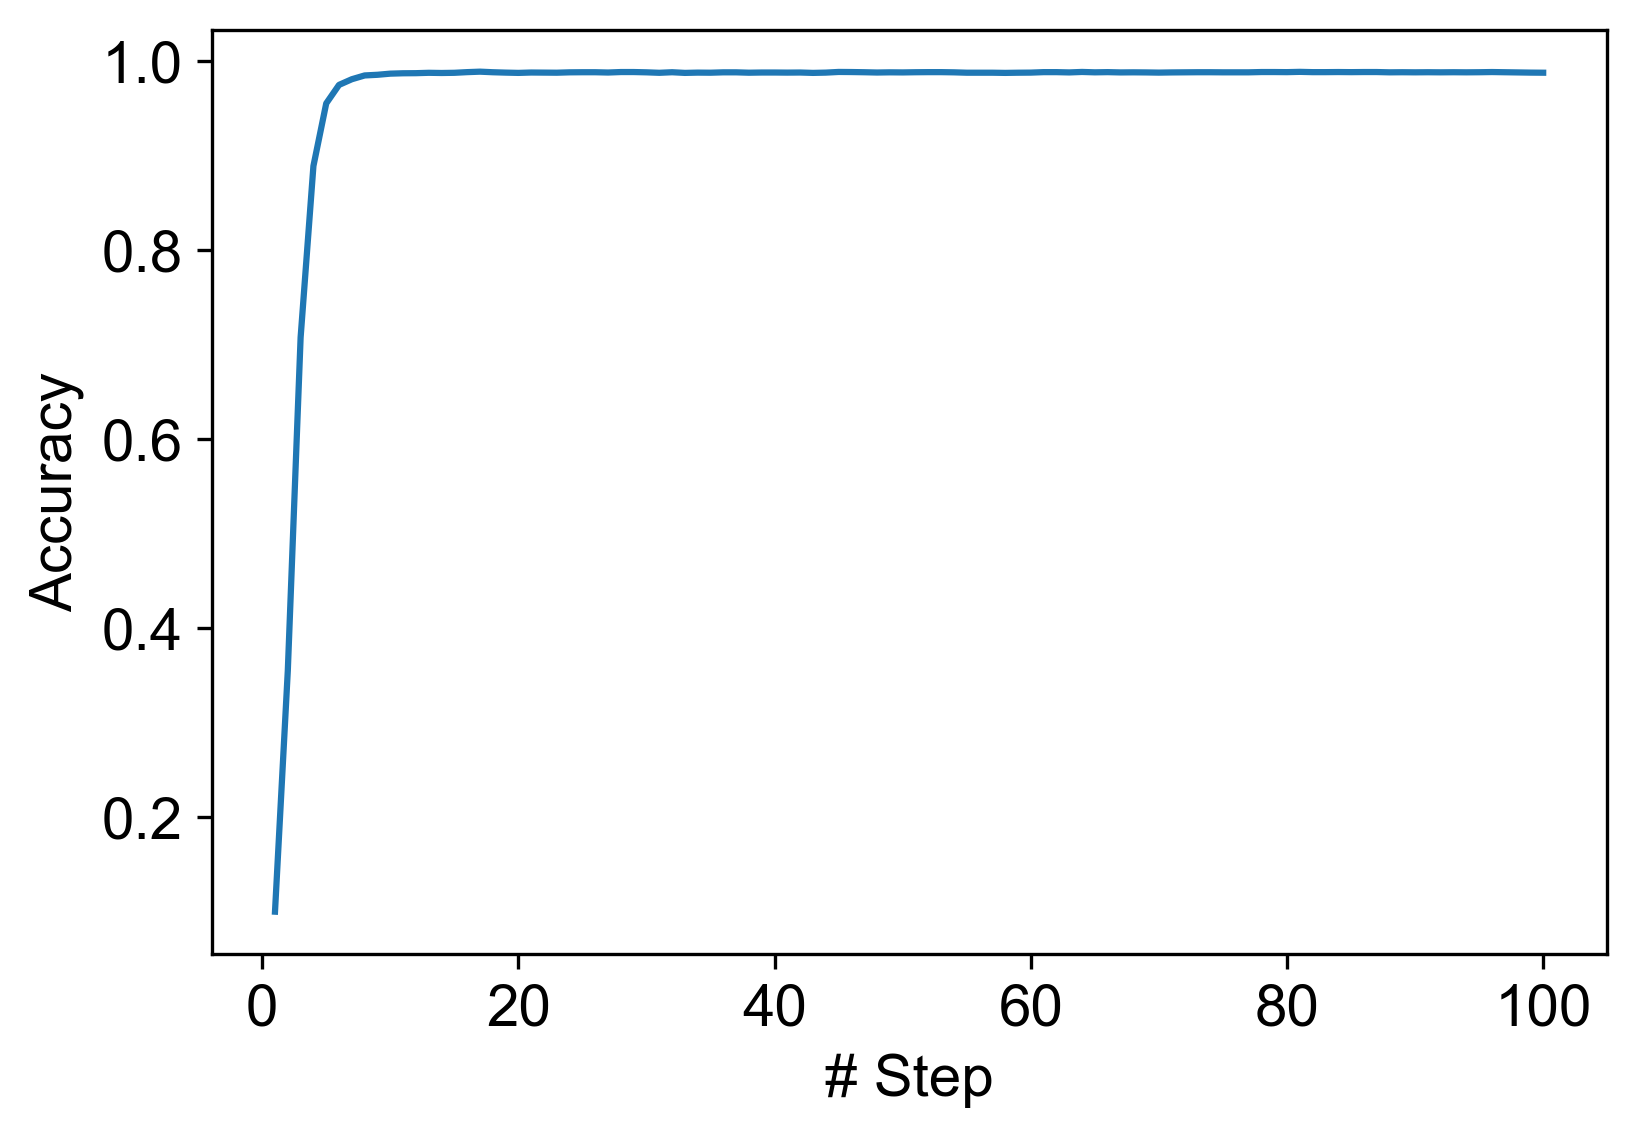

In [65]:
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(6, 4))
ax.plot(np.arange(1, cum_acc.size(0) +1) * dt, cum_acc)
ax.set_xlabel('# Step')
ax.set_ylabel('Accuracy')
plt.show()

In [66]:
start_time = 0
converge_step = torch.flip(torch.cumsum(torch.flip(cum_pred[start_time:] == cum_pred[-1].unsqueeze(0), dims=[0]), dim=0), dims=[0])
converge_step = converge_step / torch.arange(cum_acc.size(0) - start_time, 0, -1).unsqueeze(-1) / dt
converge_step = torch.argmax((converge_step==1).float(), dim=0) + start_time
print(converge_step.shape)

torch.Size([10000])


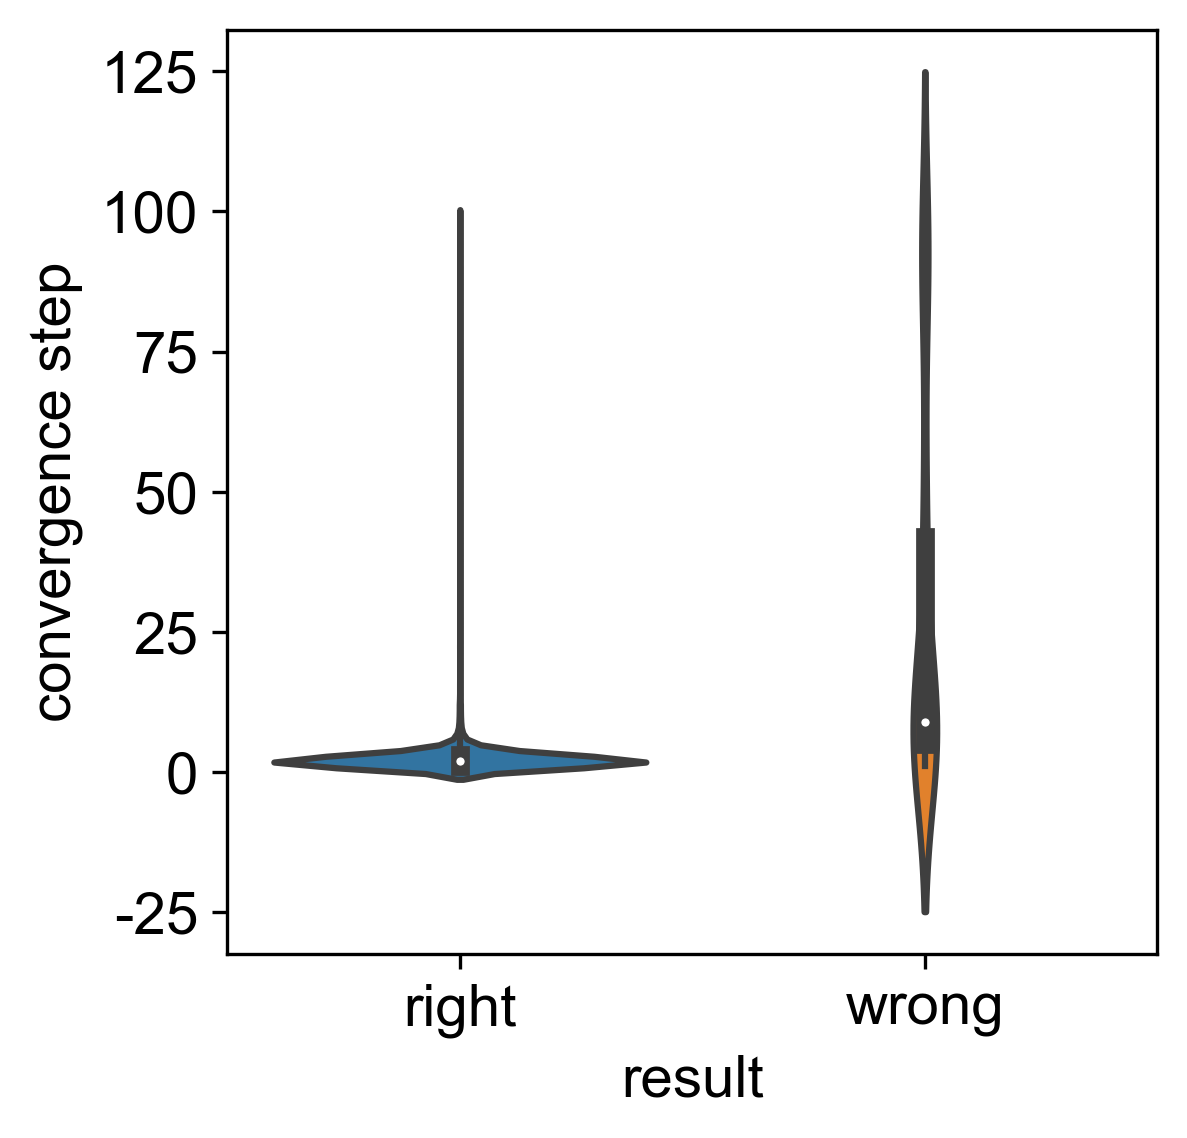

In [67]:
x = converge_step.numpy()
y = (cum_pred[-1] == targets).numpy()
y = np.where(y>=1, 'right', 'wrong')
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(4, 4))
df = pd.DataFrame({
    'convergence step': x,
    'result': y
})

sns.violinplot(data=df, x='result', y='convergence step', ax=ax)
analysis.save_fig(fig, img_dir, name + '_right_wrong_violin.pdf')
plt.show()

torch.Size([100, 10000])
2500 7500 torch.Size([100]) torch.Size([100])


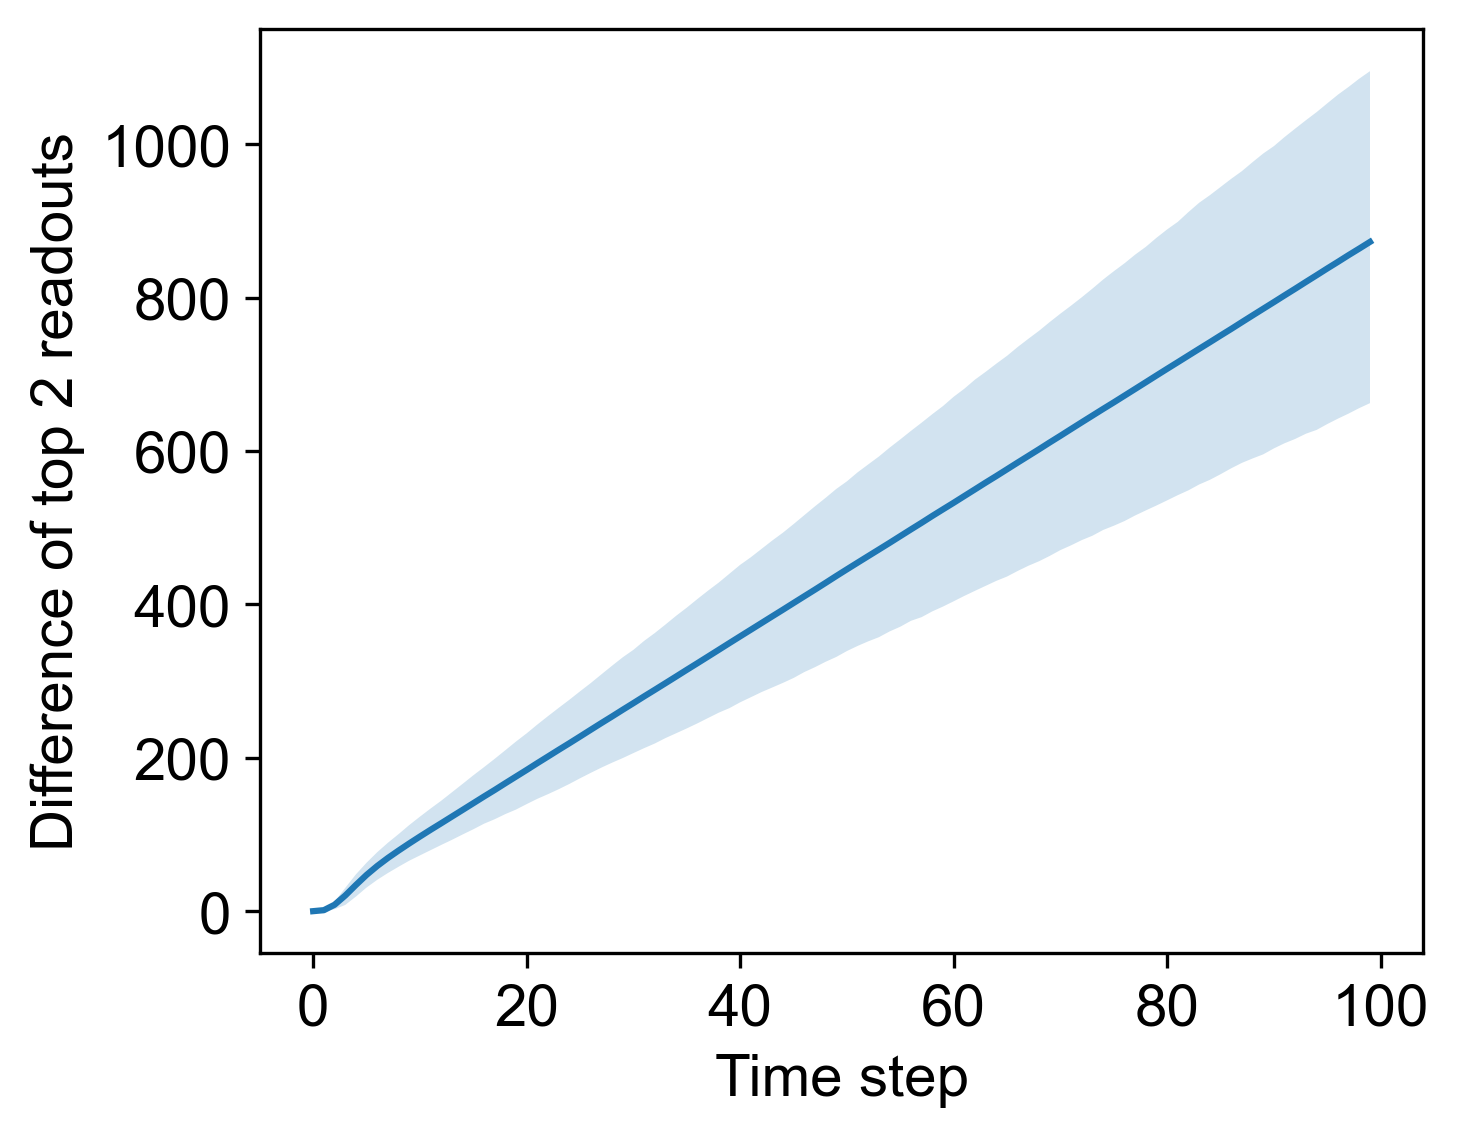

In [68]:
x = torch.topk(cum_output, dim=-1, k=2)[0]
z = x[..., 0] - x[..., 1]
print(z.shape)
m = torch.mean(z, dim=-1)
n = torch.sort(z, dim=-1)[0]
a = int(0.25 * z.shape[-1])
b = int(0.75 * z.shape[-1])
print(a, b, n[:, a].shape, n[:,b].shape)
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
ax.plot(m, label='mean')
ax.fill_between(range(len(m)), n[:, a], n[:, b], alpha=0.2, label='std')
ax.set_xlabel('Time step')
ax.set_ylabel('Difference of top 2 readouts')
analysis.save_fig(fig, img_dir, name + '_top2_gap.pdf')
plt.show()

In [69]:
lb = 5
ub = 200
steps = 150
threshods = torch.linspace(lb, ub, steps)
policy_acc = []
policy_steps = []
start_time = 0
for i in range(threshods.numel()):
    threshod = threshods[i].item()
    x, _ = torch.topk(cum_output, dim=-1, k=2)
    x = (x[..., 0] - x[..., 1]) >= threshod
    x[:start_time, ...] = 0
    x[-1, ...] = 1
    x = torch.argmax(x * 1., dim=0)
    y = x.unsqueeze(0).expand_as(cum_pred)
    y = torch.gather(cum_pred, dim=0, index=y)[0]
    policy_acc.append(torch.mean((y == targets) * 1.).item())
    policy_steps.append(torch.mean(x * 1.).item())

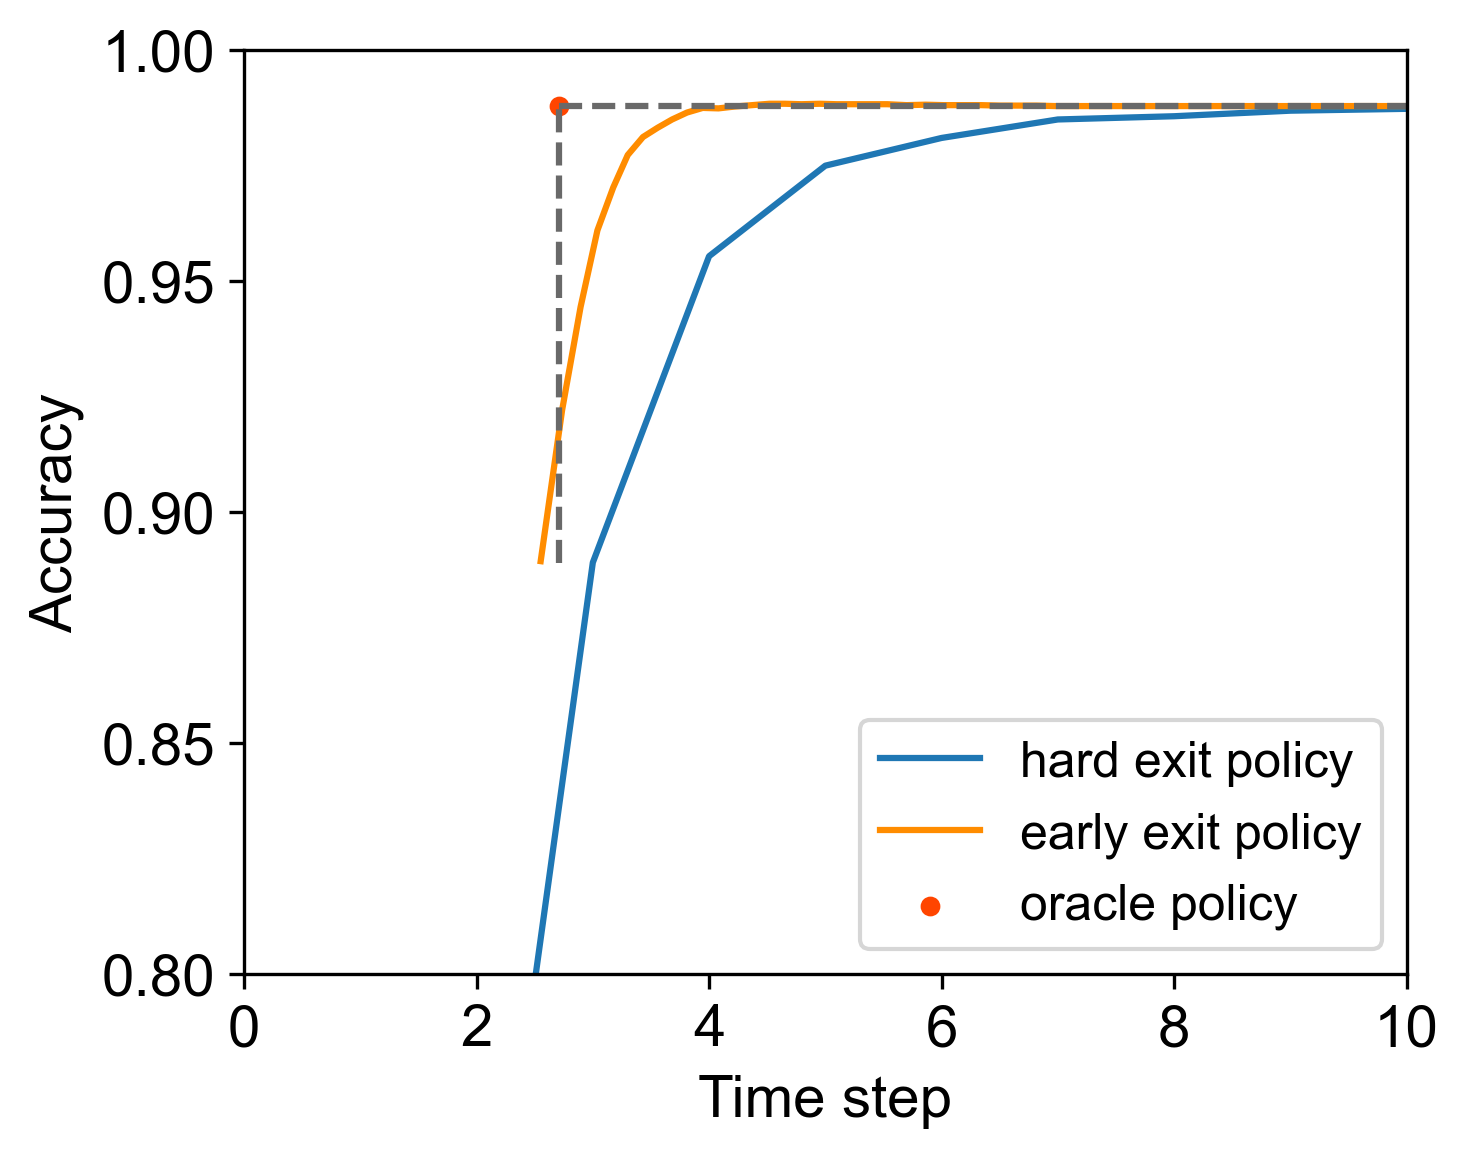

tensor(2.7095)
0.9879000186920166
[2.5513999462127686, 2.73580002784729, 2.8945000171661377, 3.0394999980926514, 3.175800085067749, 3.300100088119507, 3.4314000606536865, 3.5569000244140625, 3.681999921798706, 3.81030011177063, 3.9451000690460205, 4.08050012588501, 4.221099853515625, 4.3765997886657715, 4.519800186157227, 4.652900218963623, 4.7947001457214355, 4.952700138092041, 5.0980000495910645, 5.2515997886657715, 5.387400150299072, 5.533299922943115, 5.698999881744385, 5.862400054931641, 6.018099784851074, 6.185800075531006, 6.337699890136719, 6.5046000480651855, 6.6656999588012695, 6.81689977645874, 6.97760009765625, 7.124800205230713, 7.287700176239014, 7.446499824523926, 7.6143999099731445, 7.789100170135498, 7.94980001449585, 8.126299858093262, 8.293499946594238, 8.454999923706055, 8.623100280761719, 8.795999526977539, 8.964200019836426, 9.151900291442871, 9.318699836730957, 9.488699913024902, 9.665200233459473, 9.86359977722168, 10.026599884033203, 10.19379997253418, 10.36629

In [70]:
zoom_in = True
fig, ax = analysis.prepare_fig_axs(1, 1, dpi=300, figsize=(5, 4))
oracle_policy = torch.mean(converge_step * 1.)
hard_policy = cum_acc
ax.plot(hard_policy, label='hard exit policy',  c='C0')
ax.plot(policy_steps, policy_acc, c='darkorange', label=r'early exit policy')
ax.plot([oracle_policy, oracle_policy], [hard_policy[int(oracle_policy.item()) + 1].item(),  hard_policy[-1].item()], c='dimgrey', ls='--')
ax.plot([oracle_policy, 100], [hard_policy[-1].item(), hard_policy[-1].item()], c='dimgrey', ls='--')

ax.scatter(oracle_policy, hard_policy[-1], label='oracle policy', c='orangered', s=14)
ax.legend(fontsize=12, loc='lower right')
ax.set_xlabel('Time step')
ax.set_ylabel('Accuracy')
if zoom_in:
    ax.set_ylim(0.8, 1.)
    ax.set_xlim(0, 10)
analysis.save_fig(fig, img_dir, name + '_policy_right_wrong{}.pdf'.format('_zoom_in' if zoom_in else ''))
plt.show()
max_acc = hard_policy[-1]
rate = 0.95
hard_step = torch.argmax((hard_policy > max_acc * rate).float())
idx = torch.argmax((torch.tensor(policy_acc) > max_acc * rate).float()).item()
early_step = policy_steps[idx]
print(oracle_policy, hard_policy[-1].item(), policy_steps, policy_acc, sep='\n')
print(max_acc * rate , hard_step, early_step, threshods[idx])